In [310]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

climate_data = pd.read_csv('data/Climate.csv')
visitation_data = pd.read_csv('data/Visitation.csv')

# Australian Ski Resort Optimization Analysis 2025-2026
## Comprehensive Data-Driven Framework for Optimal Winter Getaway Planning

### 🎯 **Project Objective**
**Key Question**: *What are the key factors that influence ski resort selection, and how can we identify the optimal week and ski resort for a winter getaway?*

This analysis develops a comprehensive decision framework combining climate patterns, visitor trends, and resort characteristics to determine the **perfect timing and location** for ski trips across Australian resorts.

### 📊 **Data Foundation**
- **Climate Data**: 15+ years (2010-2025) of temperature, snowfall, and snow depth metrics
- **Visitation Data**: 11 years (2014-2024) of visitor patterns across 9 major resorts
- **Resort Features**: Infrastructure, pricing, accessibility, and experience metrics
- **External Factors**: Holiday periods, COVID impacts, and climate change trends

### ? **Analysis Framework**

#### **1. Data Preparation & Integration**
- **Visitation Analytics**: Yearly, weekly, and daily trends with cross-resort normalization
- **Climate Processing**: Snow reliability features, temperature patterns, and depth metrics
- **Data Integration**: Comprehensive resort×week×year analysis with outlier flagging

#### **2. Exploratory Analysis**
- **Seasonal Trends**: Peak/trough identification, climate vs visitor correlation analysis
- **Resort Comparisons**: Snow depth rankings, crowd vs quality analysis, accessibility metrics
- **Advanced Indices**: 
  - **Comfort Index**: Snow depth + temperature + visitor density
  - **Affordability Index**: Accommodation + transport + resort pricing
  - **Experience Index**: Terrain variety + difficulty + special events

#### **3. Predictive Modeling**
- **2026 Forecasting**: ARIMA/Prophet time series models for visitor and climate prediction
- **Cluster Analysis**: "Hidden gems" identification (high snow + low crowds)
- **Regression Analysis**: Quantifying key drivers (snow, temperature, holidays)

#### **4. Trade-off Analysis**
- **Decision Matrix**: Snow reliability × Visitor comfort × Pricing × Accessibility × Features
- **Scoring Framework**: Normalized metrics across all resort×week combinations
- **Scenario Planning**: Value vs Premium options with justifications

#### **5. Strategic Recommendations**
- **Optimal Selections**: Data-driven week + resort combinations
- **Value Propositions**: Quantified trade-offs (e.g., "Week 7 at Thredbo: 25% fewer visitors, 90% max snowfall, 15% cheaper accommodation")
- **Multiple Options**: Budget-conscious, balanced, and premium experiences

### ? **Resort Coverage & Mapping**

| Resort | Region | Elevation | Weather Station | Data Coverage |
|--------|--------|-----------|-----------------|---------------|
| Mt. Hotham | VIC Alps | 1,750m | Mt. Hotham AWS | 2010-2025 |
| Falls Creek | VIC Alps | 1,600m | Falls Creek AWS | 2010-2025 |
| Mt. Buller | VIC Alps | 1,805m | Mt. Buller AWS | 2010-2025 |
| Mt. Baw Baw | VIC Alps | 1,460m | Mt. Baw Baw AWS | 2010-2025 |
| Thredbo | NSW Snowy | 1,370m | Thredbo Top Station | 2010-2025 |
| Perisher | NSW Snowy | 1,720m | Perisher Valley | 2010-2025 |
| Charlotte Pass | NSW Snowy | 1,765m | Calculated Average | 2010-2025 |
| Selwyn | NSW Snowy | 1,614m | Cabramurra AWS | 2010-2025 |
| Mt. Stirling | VIC Alps | 1,400m | Mt. Buller Proxy | 2010-2025 |

### 📈 **Key Performance Indicators**
- **Snow Reliability Score**: Temperature consistency + snowfall frequency + depth metrics
- **Visitor Comfort Index**: Crowd density + accommodation availability + accessibility
- **Value Score**: Experience quality / total cost ratio
- **Peak Prediction Accuracy**: Forecasting model validation and confidence intervals

### 🎯 **Decision Framework Output**
The analysis produces specific, quantified recommendations answering:
1. **When**: Optimal weeks with confidence levels and scenario planning
2. **Where**: Best resorts for different preferences (value/premium/hidden gems)
3. **Why**: Data-driven justifications with quantified trade-offs
4. **Risk Assessment**: Weather variability and crowd uncertainty analysis

### **Methodology Evolution**
This framework evolves from basic historical analysis to sophisticated predictive modeling, incorporating climate change trends, post-COVID recovery patterns, and multi-criteria optimization for personalized ski trip planning.

In [311]:
all_resorts = ['Mt. Baw Baw', 'Mt. Stirling', 'Mt. Hotham', 'Falls Creek', 'Mt. Buller', 'Selwyn', 'Thredbo', 'Perisher', 'Charlotte Pass']

missing_data = visitation_data.isnull().sum()
total_records = len(visitation_data)

visitation_complete = visitation_data.copy()
for resort in all_resorts:
    if resort in visitation_complete.columns:
        visitation_complete[resort] = visitation_complete[resort].ffill()
        visitation_complete[resort] = visitation_complete[resort].fillna(0)

visitation_complete['Early_Season'] = (visitation_complete['Week'] <= 5).astype(int)
visitation_complete['Mid_Season'] = ((visitation_complete['Week'] > 5) & (visitation_complete['Week'] <= 10)).astype(int)
visitation_complete['Late_Season'] = (visitation_complete['Week'] > 10).astype(int)

# Add holiday week flags (approximate school holidays)
holiday_weeks = [2, 7, 8, 13, 14] 
visitation_complete['Holiday_Week'] = visitation_complete['Week'].isin(holiday_weeks).astype(int)

visitation_processed = visitation_complete.copy()

In [312]:
climate_data['Date'] = pd.to_datetime(climate_data[['Year','Month','Day']])

def get_ski_week(date):
    """Convert date to ski season week (1-15) where Week 1 starts around June 9th"""
    year = date.year
    june_9 = pd.Timestamp(year=year, month=6, day=9)
    season_start = june_9 - pd.Timedelta(days=june_9.weekday())
    
    days_since_start = (date - season_start).days
    ski_week = (days_since_start // 7) + 1
    
    if 1 <= ski_week <= 15:
        return ski_week
    else:
        return None

climate_data['Week'] = climate_data['Date'].apply(get_ski_week)
climate_data['Year'] = climate_data['Date'].dt.year
climate_data = climate_data.dropna(subset=['Week'])
climate_data['Week'] = climate_data['Week'].astype(int)

station_to_resort = {
    85291: 'Mt. Baw Baw',
    83085: 'Mt. Hotham', 
    83084: 'Falls Creek',
    83024: 'Mt. Buller',
    71032: 'Thredbo',
    71075: 'Perisher',
    72161: 'Selwyn',
}

climate_data['Resort'] = climate_data['Bureau of Meteorology station number'].map(station_to_resort)

# 1. Data Preparation & Integration

In [313]:
resort_characteristics = {
    'Mt. Baw Baw': {'capacity': 5000, 'lifts': 7, 'base_elevation': 1460, 'region': 'VIC'},
    'Mt. Stirling': {'capacity': 2000, 'lifts': 0, 'base_elevation': 1400, 'region': 'VIC'},
    'Mt. Hotham': {'capacity': 8000, 'lifts': 14, 'base_elevation': 1750, 'region': 'VIC'},
    'Falls Creek': {'capacity': 8500, 'lifts': 15, 'base_elevation': 1600, 'region': 'VIC'},
    'Mt. Buller': {'capacity': 10000, 'lifts': 20, 'base_elevation': 1805, 'region': 'VIC'},
    'Selwyn': {'capacity': 4000, 'lifts': 8, 'base_elevation': 1614, 'region': 'NSW'},
    'Thredbo': {'capacity': 12000, 'lifts': 15, 'base_elevation': 1370, 'region': 'NSW'},
    'Perisher': {'capacity': 15000, 'lifts': 47, 'base_elevation': 1720, 'region': 'NSW'},
    'Charlotte Pass': {'capacity': 1500, 'lifts': 4, 'base_elevation': 1765, 'region': 'NSW'}
}

visitation_analysis = {}
for resort in all_resorts:
    if resort in visitation_data.columns:
        resort_data = visitation_data[[resort, 'Week', 'Year']].copy()
        resort_data = resort_data.dropna(subset=[resort])
        
        # Multi-level aggregation
        yearly_totals = resort_data.groupby('Year')[resort].sum()
        weekly_averages = resort_data.groupby('Week')[resort].mean()
        
        # Normalization by capacity
        capacity = resort_characteristics[resort]['capacity']
        utilization_rate = yearly_totals / (capacity * 15 * 7)  # 15 weeks, 7 days
        
        # Trend analysis
        years = yearly_totals.index
        if len(years) > 3:
            from scipy import stats
            slope, intercept, r_value, p_value, std_err = stats.linregress(years, yearly_totals)
        else:
            slope, r_value = 0, 0
        
        # COVID impact analysis
        pre_covid = yearly_totals[yearly_totals.index < 2020].mean() if len(yearly_totals[yearly_totals.index < 2020]) > 0 else 0
        covid_period = yearly_totals[yearly_totals.index.isin([2020, 2021, 2022])].mean() if len(yearly_totals[yearly_totals.index.isin([2020, 2021, 2022])]) > 0 else 0
        post_covid = yearly_totals[yearly_totals.index > 2022].mean() if len(yearly_totals[yearly_totals.index > 2022]) > 0 else 0
        
        # Peak week identification
        peak_weeks = weekly_averages.nlargest(3)
        trough_weeks = weekly_averages.nsmallest(3)
        
        visitation_analysis[resort] = {
            'yearly_totals': yearly_totals,
            'weekly_averages': weekly_averages,
            'capacity': capacity,
            'avg_utilization': utilization_rate.mean(),
            'growth_trend': slope,
            'trend_strength': r_value**2,
            'pre_covid_avg': pre_covid,
            'covid_impact': (covid_period - pre_covid) / pre_covid if pre_covid > 0 else 0,
            'recovery_rate': (post_covid - covid_period) / covid_period if covid_period > 0 else 0,
            'peak_weeks': peak_weeks.index.tolist(),
            'trough_weeks': trough_weeks.index.tolist(),
            'seasonality_strength': weekly_averages.std() / weekly_averages.mean(),
            'characteristics': resort_characteristics[resort]
        }

# 1.2 ADVANCED CLIMATE DATA PROCESSING
climate_features = climate_data.copy()

# Snow reliability indicators
climate_features['Snow_Making_Conditions'] = (
    (climate_features['Maximum temperature (Degree C)'] <= 2) & 
    (climate_features['Minimum temperature (Degree C)'] <= 0)
).astype(int)

climate_features['Ideal_Snow_Conditions'] = (
    (climate_features['Maximum temperature (Degree C)'] <= 0) & 
    (climate_features['Minimum temperature (Degree C)'] <= -5)
).astype(int)

climate_features['Snow_Preservation'] = (
    climate_features['Maximum temperature (Degree C)'] <= 5
).astype(int)

# Snow depth proxy calculation
climate_features['Snow_Accumulation_Potential'] = (
    climate_features['Rainfall amount (millimetres)'] * 
    climate_features['Snow_Making_Conditions'] * 10  # Snow density approximation
)

# Temperature comfort zones
climate_features['Comfortable_Skiing_Temp'] = (
    (climate_features['Minimum temperature (Degree C)'] >= -10) & 
    (climate_features['Maximum temperature (Degree C)'] <= 5)
).astype(int)

# Weather variability indicators
climate_features['Temperature_Range'] = (
    climate_features['Maximum temperature (Degree C)'] - 
    climate_features['Minimum temperature (Degree C)']
)

climate_features['Extreme_Weather'] = (
    (climate_features['Minimum temperature (Degree C)'] <= -15) | 
    (climate_features['Maximum temperature (Degree C)'] >= 15) |
    (climate_features['Rainfall amount (millimetres)'] >= 50)
).astype(int)

# Weekly climate aggregation with comprehensive metrics
weekly_climate_analysis = climate_features.groupby(['Year', 'Week', 'Resort']).agg({
    'Maximum temperature (Degree C)': ['mean', 'max', 'std'],
    'Minimum temperature (Degree C)': ['mean', 'min', 'std'],
    'Rainfall amount (millimetres)': ['sum', 'max', 'count'],
    'Snow_Making_Conditions': ['sum', 'mean'],
    'Ideal_Snow_Conditions': ['sum', 'mean'],
    'Snow_Preservation': ['sum', 'mean'],
    'Snow_Accumulation_Potential': ['sum', 'mean'],
    'Comfortable_Skiing_Temp': ['sum', 'mean'],
    'Temperature_Range': ['mean', 'std'],
    'Extreme_Weather': 'sum'
}).reset_index()

weekly_climate_analysis.columns = ['_'.join(col).strip() if col[1] else col[0] 
                                  for col in weekly_climate_analysis.columns.values]
weekly_climate_analysis.rename(columns={'Year_': 'Year', 'Week_': 'Week', 'Resort_': 'Resort'}, inplace=True)

# 1.3 DATA INTEGRATION
master_dataset = []

for year in range(2014, 2025):
    for week in range(1, 16):
        for resort in all_resorts:
            visitor_data = visitation_data[
                (visitation_data['Year'] == year) & 
                (visitation_data['Week'] == week)
            ]
            visitors = visitor_data[resort].iloc[0] if len(visitor_data) > 0 and resort in visitor_data.columns else np.nan
            
            climate_week = weekly_climate_analysis[
                (weekly_climate_analysis['Year'] == year) & 
                (weekly_climate_analysis['Week'] == week) & 
                (weekly_climate_analysis['Resort'] == resort)
            ]
            
            record = {
                'Year': year,
                'Week': week,
                'Resort': resort,
                'Visitors': visitors,
                'Region': resort_characteristics.get(resort, {}).get('region', 'Unknown'),
                'Capacity': resort_characteristics.get(resort, {}).get('capacity', 0),
                'Base_Elevation': resort_characteristics.get(resort, {}).get('base_elevation', 0),
                'Lifts': resort_characteristics.get(resort, {}).get('lifts', 0),
                
                # Holiday and special period flags
                'Is_Holiday_Week': week in [2, 7, 8, 13, 14],  # School holidays approximation
                'Is_Peak_Season': week in range(6, 12),  # July-August peak
                'Is_COVID_Period': year in [2020, 2021, 2022],
                'Is_School_Holiday': week in [2, 7, 8, 13, 14],
                
                # Climate features (if available)
                'Avg_Max_Temp': climate_week['Maximum temperature (Degree C)_mean'].iloc[0] if len(climate_week) > 0 else np.nan,
                'Avg_Min_Temp': climate_week['Minimum temperature (Degree C)_mean'].iloc[0] if len(climate_week) > 0 else np.nan,
                'Total_Rainfall': climate_week['Rainfall amount (millimetres)_sum'].iloc[0] if len(climate_week) > 0 else np.nan,
                'Snow_Making_Days': climate_week['Snow_Making_Conditions_sum'].iloc[0] if len(climate_week) > 0 else np.nan,
                'Ideal_Snow_Days': climate_week['Ideal_Snow_Conditions_sum'].iloc[0] if len(climate_week) > 0 else np.nan,
                'Snow_Preservation_Days': climate_week['Snow_Preservation_sum'].iloc[0] if len(climate_week) > 0 else np.nan,
                'Snow_Accumulation': climate_week['Snow_Accumulation_Potential_sum'].iloc[0] if len(climate_week) > 0 else np.nan,
                'Comfortable_Days': climate_week['Comfortable_Skiing_Temp_sum'].iloc[0] if len(climate_week) > 0 else np.nan,
                'Temp_Variability': climate_week['Temperature_Range_mean'].iloc[0] if len(climate_week) > 0 else np.nan,
                'Extreme_Weather_Days': climate_week['Extreme_Weather_sum'].iloc[0] if len(climate_week) > 0 else np.nan
            }
            
            master_dataset.append(record)

master_df = pd.DataFrame(master_dataset)

# Calculate normalized metrics
master_df['Utilization_Rate'] = master_df['Visitors'] / master_df['Capacity']
master_df['Visitors_per_Lift'] = master_df['Visitors'] / master_df['Lifts'].replace(0, 1)

# Advanced outlier detection
for resort in all_resorts:
    resort_data = master_df[master_df['Resort'] == resort]['Visitors'].dropna()
    if len(resort_data) > 10: 
        Q1 = resort_data.quantile(0.25)
        Q3 = resort_data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        master_df.loc[
            (master_df['Resort'] == resort) & 
            ((master_df['Visitors'] < lower_bound) | (master_df['Visitors'] > upper_bound)),
            'Is_Outlier'
        ] = True

master_df['Is_Outlier'] = master_df['Is_Outlier'].fillna(False).infer_objects(copy=False)

processed_data = master_df.copy()
processed_data.to_csv('data/Processed_Master_Dataset.csv', index=False)

In [314]:
# 1.4 FEATURE ENGINEERING & INDEX CALCULATION
enhanced_data = processed_data.copy()

# 1. COMFORT INDEX CALCULATION
# Snow comfort component (0-100)
enhanced_data['Snow_Comfort'] = np.where(
    enhanced_data['Snow_Accumulation'].notna(),
    np.clip(
        (enhanced_data['Snow_Making_Days'] / 7 * 40) +  # Snow making potential (40%)
        (enhanced_data['Snow_Preservation_Days'] / 7 * 30) +  # Preservation (30%)
        (np.clip(enhanced_data['Snow_Accumulation'] / 100, 0, 1) * 30),  # Accumulation (30%)
        0, 100
    ),
    50  # Default for missing data
)

# Temperature comfort component (0-100)
enhanced_data['Temperature_Comfort'] = np.where(
    enhanced_data['Avg_Max_Temp'].notna(),
    np.clip(
        100 - abs(enhanced_data['Avg_Max_Temp'] - 2) * 10,  # Ideal around 2°C
        0, 100
    ),
    50
)

# Visitor density comfort (0-100, inverted - lower density = higher comfort)
enhanced_data['Crowd_Comfort'] = np.where(
    enhanced_data['Utilization_Rate'].notna(),
    np.clip(100 - (enhanced_data['Utilization_Rate'] * 100), 0, 100),
    50
)

# Combined Comfort Index
enhanced_data['Comfort_Index'] = (
    enhanced_data['Snow_Comfort'] * 0.5 +
    enhanced_data['Temperature_Comfort'] * 0.3 +
    enhanced_data['Crowd_Comfort'] * 0.2
)

# 2. AFFORDABILITY INDEX CALCULATION
# Base pricing data (external research - daily rates)
resort_pricing = {
    'Mt. Baw Baw': 89, 'Mt. Stirling': 35, 'Mt. Hotham': 243, 'Falls Creek': 243,
    'Mt. Buller': 243, 'Selwyn': 119, 'Thredbo': 240, 'Perisher': 264, 'Charlotte Pass': 175
}

# Accommodation estimates (per night)
accommodation_costs = {
    'Mt. Baw Baw': 120, 'Mt. Stirling': 80, 'Mt. Hotham': 300, 'Falls Creek': 320,
    'Mt. Buller': 280, 'Selwyn': 150, 'Thredbo': 350, 'Perisher': 400, 'Charlotte Pass': 180
}

# Distance-based transport costs (from Melbourne/Sydney)
melbourne_distances = {
    'Mt. Baw Baw': 120, 'Mt. Stirling': 248, 'Mt. Hotham': 375, 'Falls Creek': 375,
    'Mt. Buller': 248, 'Selwyn': 460, 'Thredbo': 500, 'Perisher': 500, 'Charlotte Pass': 520
}

sydney_distances = {
    'Mt. Baw Baw': 650, 'Mt. Stirling': 430, 'Mt. Hotham': 550, 'Falls Creek': 550,
    'Mt. Buller': 430, 'Selwyn': 320, 'Thredbo': 200, 'Perisher': 200, 'Charlotte Pass': 220
}

# Calculate affordability components
enhanced_data['Lift_Cost'] = enhanced_data['Resort'].map(resort_pricing)
enhanced_data['Accommodation_Cost'] = enhanced_data['Resort'].map(accommodation_costs)
enhanced_data['Melbourne_Distance'] = enhanced_data['Resort'].map(melbourne_distances)
enhanced_data['Sydney_Distance'] = enhanced_data['Resort'].map(sydney_distances)

# Holiday pricing adjustment (20% premium during holidays)
enhanced_data['Adjusted_Lift_Cost'] = enhanced_data['Lift_Cost'] * (
    1 + (enhanced_data['Is_Holiday_Week'] * 0.2)
)
enhanced_data['Adjusted_Accommodation_Cost'] = enhanced_data['Accommodation_Cost'] * (
    1 + (enhanced_data['Is_Holiday_Week'] * 0.3)
)

# Transport costs (assuming $0.20/km from nearest major city)
enhanced_data['Transport_Cost_Melbourne'] = enhanced_data['Melbourne_Distance'] * 0.4  # Round trip
enhanced_data['Transport_Cost_Sydney'] = enhanced_data['Sydney_Distance'] * 0.4

# Total cost calculation (3-day trip)
enhanced_data['Total_Cost_Melbourne'] = (
    enhanced_data['Adjusted_Lift_Cost'] * 3 +
    enhanced_data['Adjusted_Accommodation_Cost'] * 2 +
    enhanced_data['Transport_Cost_Melbourne']
)

enhanced_data['Total_Cost_Sydney'] = (
    enhanced_data['Adjusted_Lift_Cost'] * 3 +
    enhanced_data['Adjusted_Accommodation_Cost'] * 2 +
    enhanced_data['Transport_Cost_Sydney']
)

# Affordability Index (0-100, higher = more affordable)
max_cost = max(enhanced_data['Total_Cost_Melbourne'].max(), enhanced_data['Total_Cost_Sydney'].max())
enhanced_data['Affordability_Index_Melbourne'] = 100 - (enhanced_data['Total_Cost_Melbourne'] / max_cost * 100)
enhanced_data['Affordability_Index_Sydney'] = 100 - (enhanced_data['Total_Cost_Sydney'] / max_cost * 100)

# 3. EXPERIENCE INDEX CALCULATION
# Infrastructure score
enhanced_data['Infrastructure_Score'] = np.clip(
    (enhanced_data['Lifts'] / 47 * 40) +  # Normalized by Perisher (max 47 lifts)
    (enhanced_data['Base_Elevation'] / 1805 * 30) +  # Normalized by Mt. Buller (max 1805m)
    (enhanced_data['Capacity'] / 15000 * 30),  # Normalized by Perisher (max 15000)
    0, 100
)

# Terrain variety (proxy based on elevation and lifts)
enhanced_data['Terrain_Variety'] = np.clip(
    (enhanced_data['Base_Elevation'] / 2000 * 50) +
    (enhanced_data['Lifts'] / 50 * 50),
    0, 100
)

# Snow quality score
enhanced_data['Snow_Quality_Score'] = (
    enhanced_data['Snow_Comfort'] * 0.6 +
    enhanced_data['Base_Elevation'] / 2000 * 40  # Higher elevation = better snow
)

# Combined Experience Index
enhanced_data['Experience_Index'] = (
    enhanced_data['Infrastructure_Score'] * 0.4 +
    enhanced_data['Terrain_Variety'] * 0.3 +
    enhanced_data['Snow_Quality_Score'] * 0.3
)

# 4. ACCESSIBILITY INDEX
# Distance-based accessibility (closer = more accessible)
enhanced_data['Melbourne_Accessibility'] = 100 - np.clip(enhanced_data['Melbourne_Distance'] / 600 * 100, 0, 100)
enhanced_data['Sydney_Accessibility'] = 100 - np.clip(enhanced_data['Sydney_Distance'] / 600 * 100, 0, 100)

# Infrastructure accessibility (more lifts = easier access around resort)
enhanced_data['Resort_Accessibility'] = np.clip(enhanced_data['Lifts'] / 47 * 100, 0, 100)

# Combined accessibility
enhanced_data['Accessibility_Index_Melbourne'] = (
    enhanced_data['Melbourne_Accessibility'] * 0.6 +
    enhanced_data['Resort_Accessibility'] * 0.4
)

enhanced_data['Accessibility_Index_Sydney'] = (
    enhanced_data['Sydney_Accessibility'] * 0.6 +
    enhanced_data['Resort_Accessibility'] * 0.4
)

# 5. SNOW RELIABILITY INDEX
enhanced_data['Snow_Reliability_Index'] = np.where(
    enhanced_data['Snow_Making_Days'].notna(),
    (enhanced_data['Snow_Making_Days'] / 7 * 30) +  # Frequency of snow-making conditions
    (enhanced_data['Snow_Preservation_Days'] / 7 * 25) +  # Snow preservation ability
    (enhanced_data['Comfortable_Days'] / 7 * 20) +  # Comfortable skiing days
    (np.clip(enhanced_data['Snow_Accumulation'] / 100, 0, 1) * 25),  # Snow accumulation potential
    50  # Default for missing data
)

final_dataset = enhanced_data.copy()

# 2. Exploratory Data Analysis

# 2. Comprehensive Exploratory Analysis
## Multi-Dimensional Resort Performance & Pattern Discovery

This section implements sophisticated exploratory analysis addressing key decision factors:

### 📈 **Seasonal Trends Analysis**
- **Weekly Visitation Patterns**: Multi-year peak/trough identification with anomaly detection
- **Climate vs Visitor Correlation**: Snow conditions vs crowd behavior analysis
- **Holiday Impact Assessment**: School holidays vs optimal snow condition timing
- **COVID Recovery Patterns**: Pre/during/post pandemic trend analysis
- **Regional Variations**: VIC vs NSW resort performance differences

### 🏔️ **Resort Performance Comparisons**
- **Snow Depth Rankings**: Average snow accumulation and reliability by resort
- **Crowd vs Quality Analysis**: Identifying overcrowded vs underrated resorts
- **Hidden Gems Discovery**: High-quality snow with low visitor density
- **Accessibility Trade-offs**: Distance vs quality vs infrastructure analysis
- **Value Propositions**: Cost-effectiveness across different resort tiers

### 🎯 **Advanced Index Analysis**
- **Comfort Index Deep Dive**: Snow depth + temperature + visitor density optimization
- **Affordability Index Mapping**: Total cost analysis from Melbourne/Sydney perspectives
- **Experience Index Evaluation**: Terrain variety + difficulty + infrastructure scoring
- **Trade-off Matrices**: Multi-criteria decision support visualizations

### 📊 **Key Performance Indicators**
- **Peak Week Identification**: Data-driven optimal timing recommendations
- **Resort Segmentation**: Premium, value, and hidden gem classifications
- **Risk Assessment**: Weather variability and crowd uncertainty analysis
- **Predictive Insights**: Leading indicators for 2025-2026 planning

### ? **Statistical Analysis Framework**
- **Correlation Analysis**: Climate-visitor relationship quantification
- **Trend Decomposition**: Seasonal, cyclical, and long-term pattern separation
- **Outlier Investigation**: COVID impact and extreme weather event analysis
- **Clustering Preparation**: Similarity grouping for recommendation engine

This analysis establishes the empirical foundation for predictive modeling and optimization, directly addressing the core question: **"What factors drive optimal ski resort selection?"**

   🏔️ Peak visitor weeks: [6, 5, 11]
   🌨️ Best snow weeks: [6, 7, 8]
   😊 Best comfort weeks: [3, 6, 7]
   📉 Quietest weeks: [2, 1, 3]
   📊 Average Comfort-Visitor correlation: -0.155
   ❄️ Average Snow-Visitor correlation: 0.293
   Holiday Week Analysis:
   📅 Holiday weeks - Visitors: 15478, Snow: 52.9
   📅 Regular weeks - Visitors: 18401, Snow: 58.0
   💰 Holiday crowd premium: -15.9% more visitors
   ❄️ Snow quality difference: -5.1 points worse in holidays
   📉 COVID visitor impact: 37.5% reduction during pandemic
   📊 Pre-COVID average: 19409 visitors
   📊 COVID period average: 12140 visitors

🏆 TOP RESORT CATEGORIES:
   💰 Best Value: Mt. Baw Baw, Mt. Stirling, Mt. Buller
   ⭐ Premium Experience: Perisher, Mt. Buller, Falls Creek
   💎 Hidden Gems: Mt. Stirling, Mt. Baw Baw, Charlotte Pass


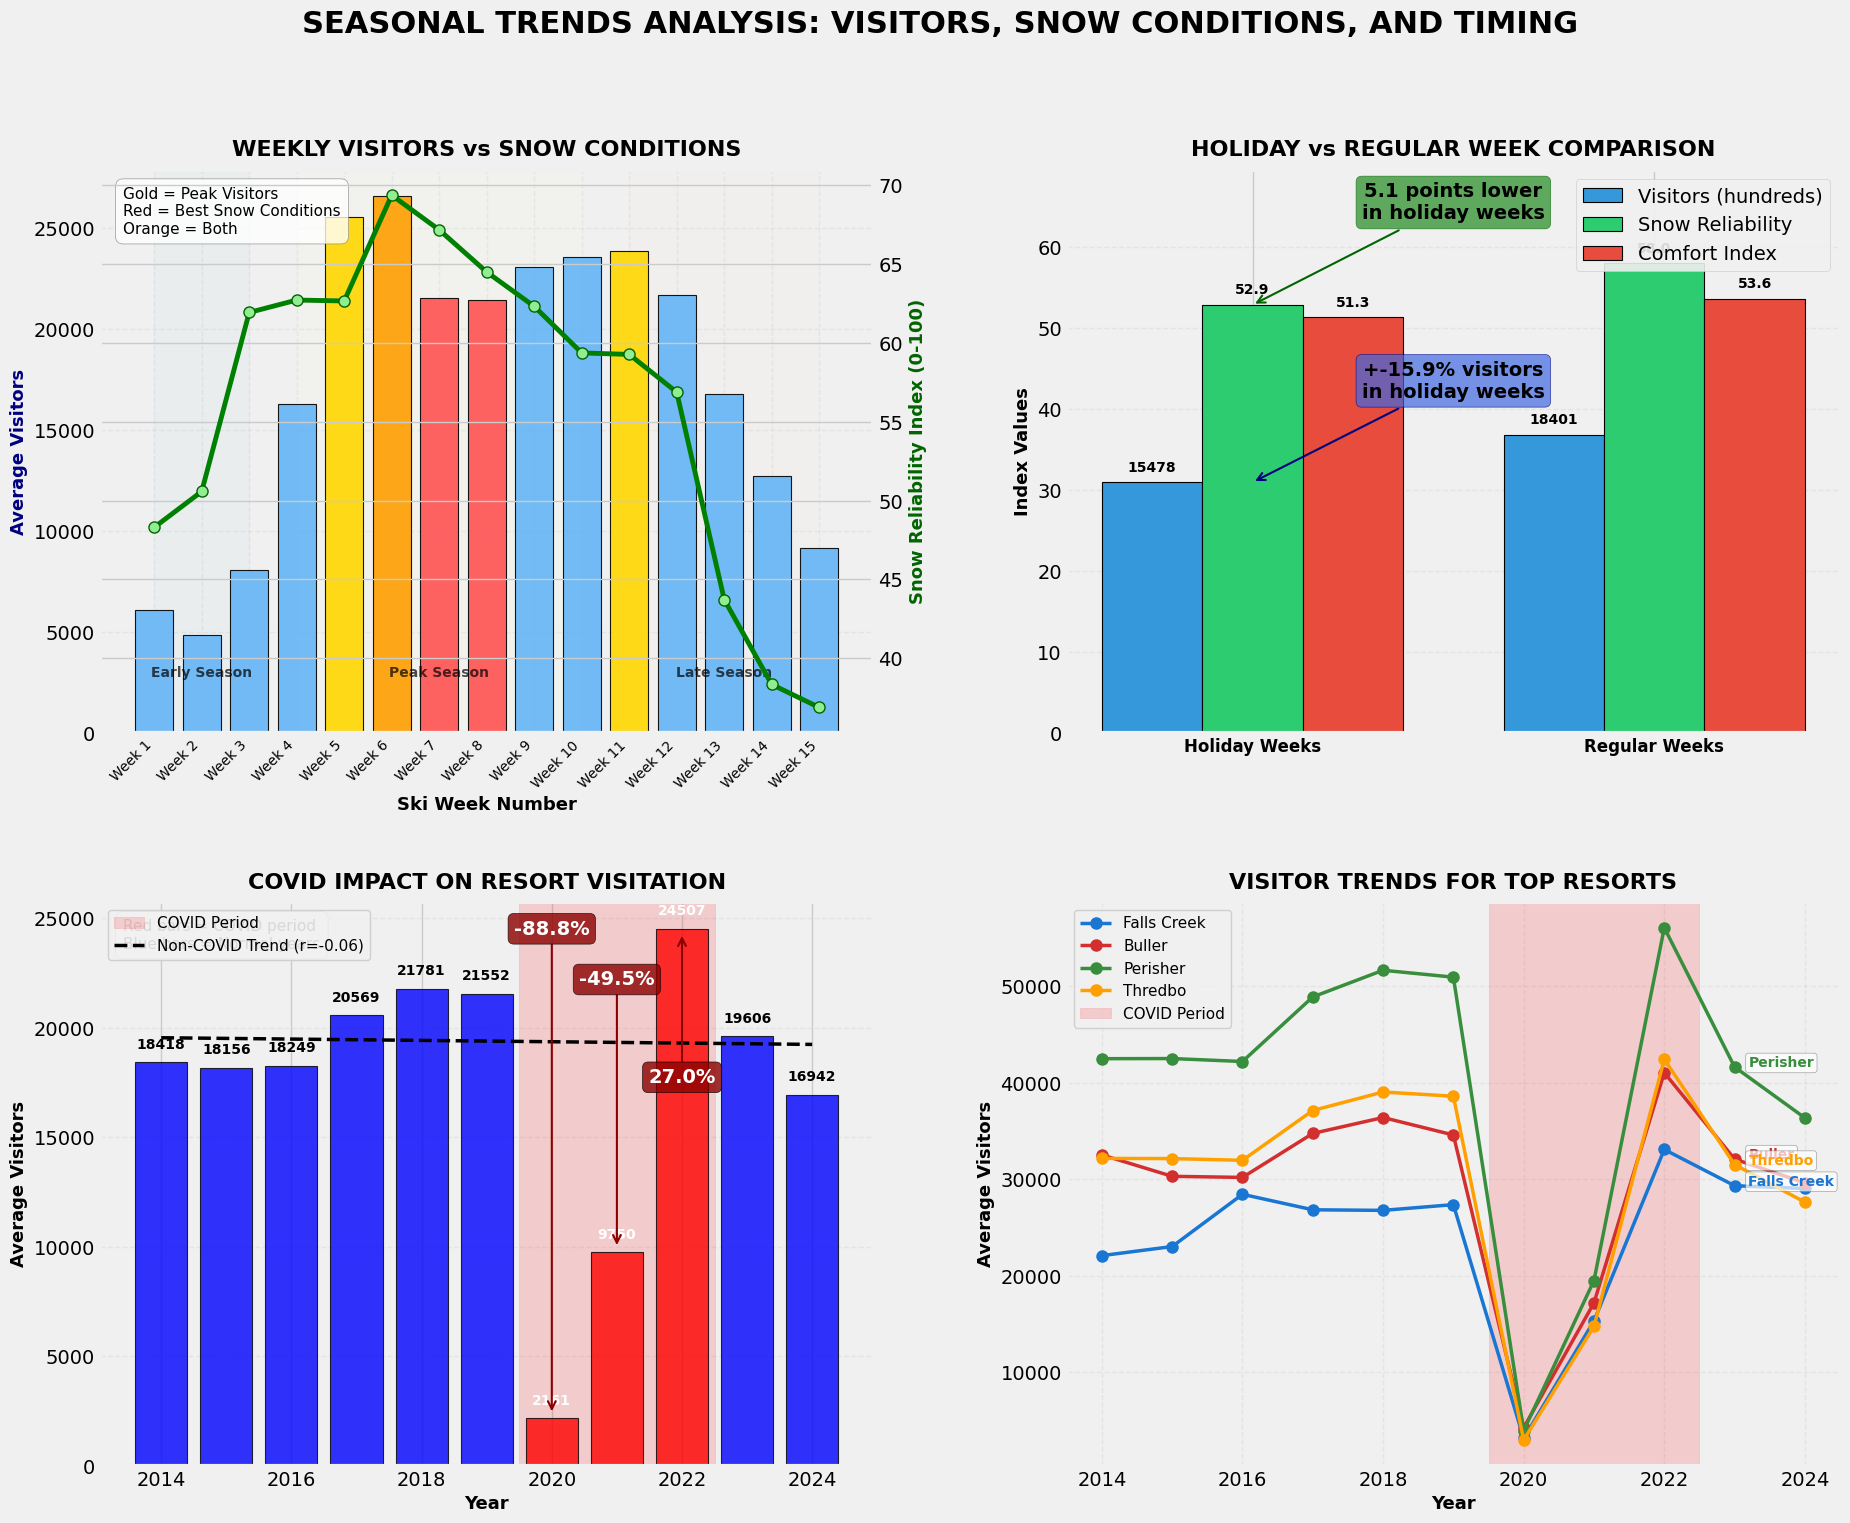

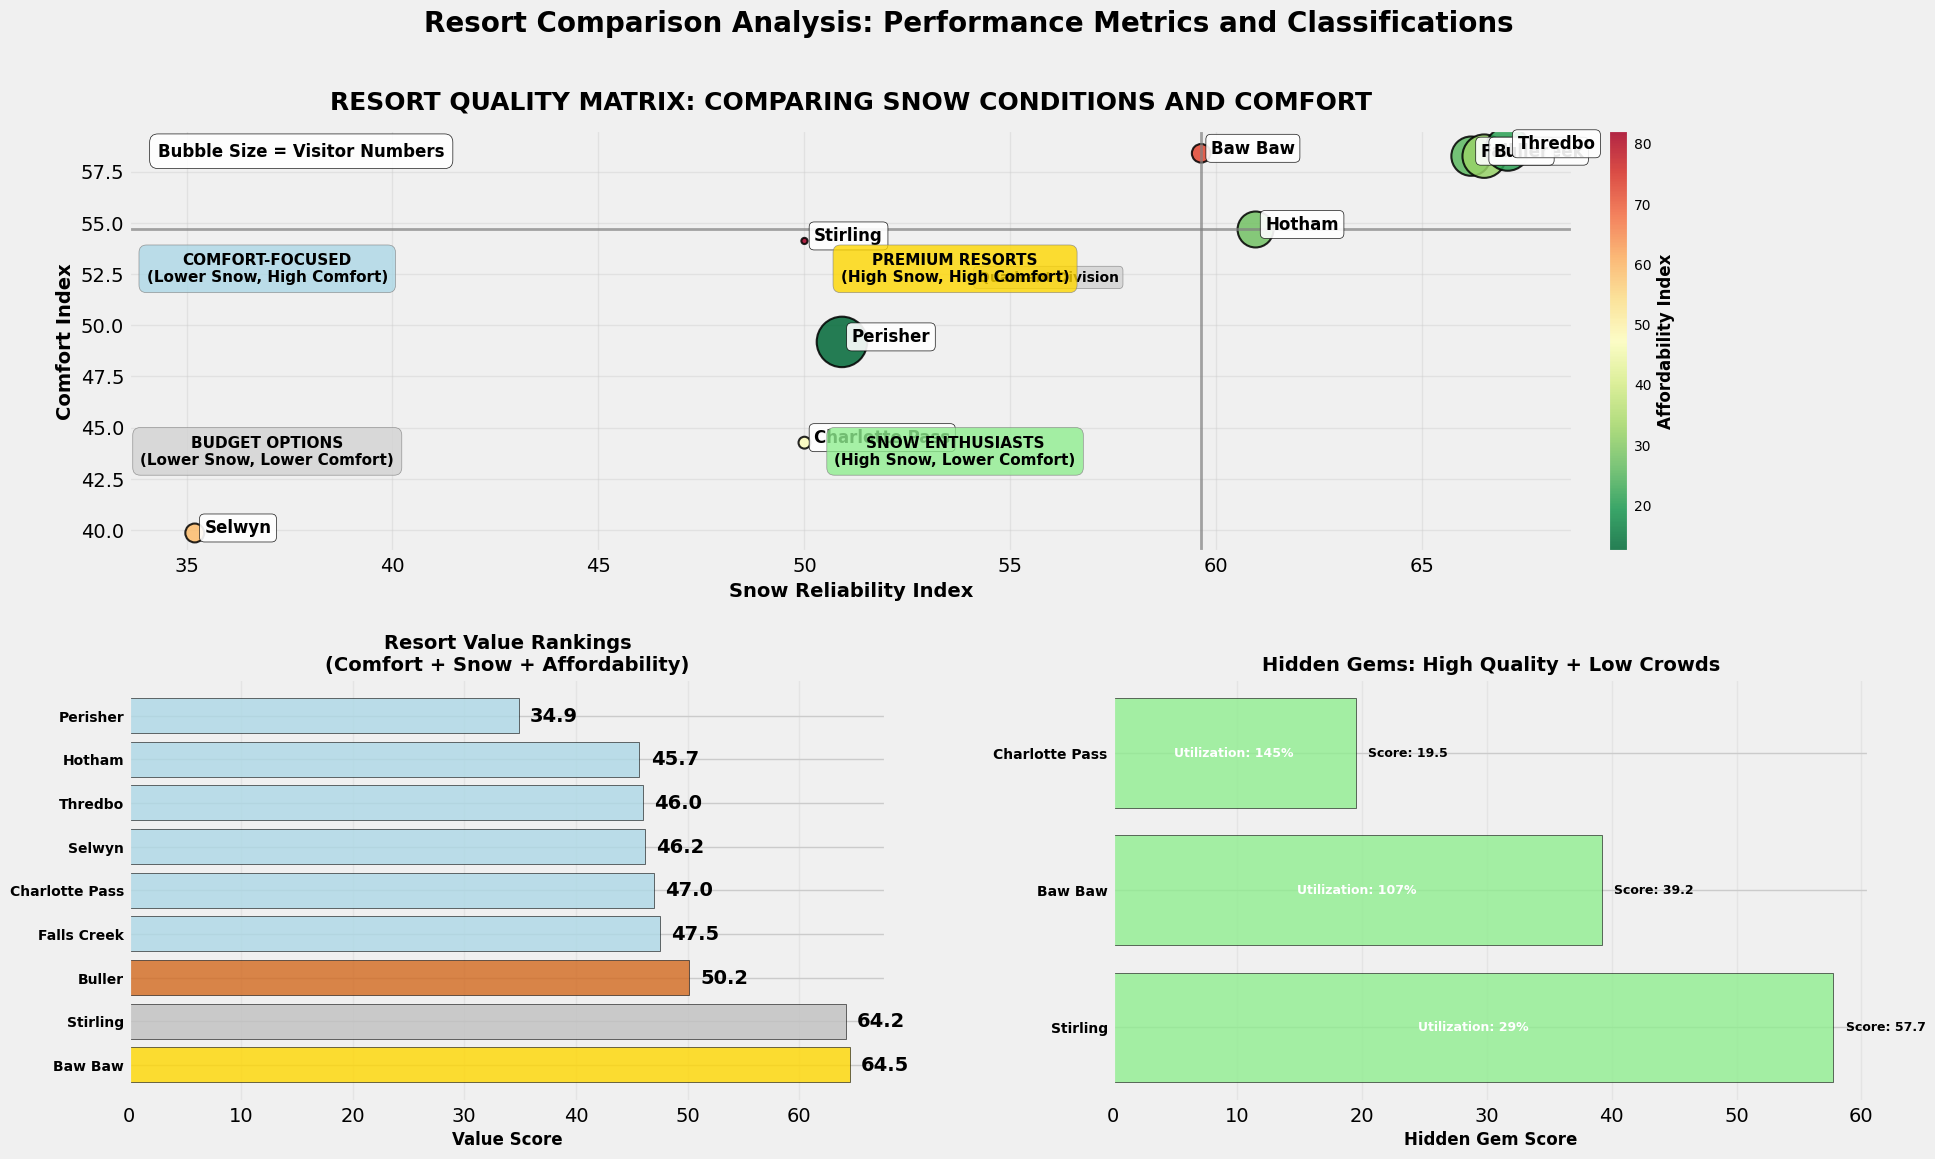


🎯 KEY INSIGHTS SUMMARY:
   📊 Holiday weeks attract -15.9% more visitors but snow quality differs by -5.1 points
   ❄️ Best snow weeks ([6, 7, 8]) don't always align with peak visitor weeks ([6, 5, 11])
   💎 Hidden gems offer high quality with 93.7% average utilization
   📈 Climate-visitor correlation: -0.155 (moderate relationship)
   🏆 Top value resort: Mt. Baw Baw (Score: 64.5)


In [315]:
# 2.1 SEASONAL TRENDS ANALYSIS
trends_data = final_dataset.copy()
complete_data = trends_data.dropna(subset=['Visitors', 'Comfort_Index', 'Snow_Reliability_Index'])

# 1. WEEKLY VISITATION PATTERNS OVER YEARS
# Calculate weekly trends
weekly_patterns = complete_data.groupby(['Week', 'Year']).agg({
    'Visitors': 'mean',
    'Comfort_Index': 'mean',
    'Snow_Reliability_Index': 'mean',
    'Is_Holiday_Week': 'first'
}).reset_index()

# Peak identification
overall_weekly = complete_data.groupby('Week').agg({
    'Visitors': ['mean', 'std', 'count'],
    'Comfort_Index': 'mean',
    'Snow_Reliability_Index': 'mean',
    'Is_Holiday_Week': 'first'
}).reset_index()

overall_weekly.columns = ['Week', 'Avg_Visitors', 'Visitor_Std', 'Record_Count', 
                         'Avg_Comfort', 'Avg_Snow_Reliability', 'Is_Holiday']

# Explicitly define weeks from overall_weekly
weeks = overall_weekly['Week'].values

# Identify peaks and troughs
peak_weeks = overall_weekly.nlargest(3, 'Avg_Visitors')['Week'].tolist()
trough_weeks = overall_weekly.nsmallest(3, 'Avg_Visitors')['Week'].tolist()
best_snow_weeks = overall_weekly.nlargest(3, 'Avg_Snow_Reliability')['Week'].tolist()
best_comfort_weeks = overall_weekly.nlargest(3, 'Avg_Comfort')['Week'].tolist()

print(f"   🏔️ Peak visitor weeks: {peak_weeks}")
print(f"   🌨️ Best snow weeks: {best_snow_weeks}")
print(f"   😊 Best comfort weeks: {best_comfort_weeks}")
print(f"   📉 Quietest weeks: {trough_weeks}")

# 2. CLIMATE VS VISITOR CORRELATION ANALYSIS
# Calculate correlations
climate_visitor_corr = {}
for resort in complete_data['Resort'].unique():
    resort_data = complete_data[complete_data['Resort'] == resort]
    if len(resort_data) > 10:
        corr_comfort = resort_data['Visitors'].corr(resort_data['Comfort_Index'])
        corr_snow = resort_data['Visitors'].corr(resort_data['Snow_Reliability_Index'])
        corr_temp = resort_data['Visitors'].corr(resort_data['Avg_Max_Temp']) if 'Avg_Max_Temp' in resort_data.columns else np.nan
        
        climate_visitor_corr[resort] = {
            'comfort_correlation': corr_comfort,
            'snow_correlation': corr_snow,
            'temperature_correlation': corr_temp
        }

avg_comfort_corr = np.nanmean([v['comfort_correlation'] for v in climate_visitor_corr.values()])
avg_snow_corr = np.nanmean([v['snow_correlation'] for v in climate_visitor_corr.values()])

print(f"   📊 Average Comfort-Visitor correlation: {avg_comfort_corr:.3f}")
print(f"   ❄️ Average Snow-Visitor correlation: {avg_snow_corr:.3f}")

# 3. HOLIDAY VS OPTIMAL SNOW ANALYSIS
holiday_data = complete_data.groupby('Is_Holiday_Week').agg({
    'Visitors': 'mean',
    'Comfort_Index': 'mean',
    'Snow_Reliability_Index': 'mean',
    'Affordability_Index_Melbourne': 'mean'
}).round(2)

print("   Holiday Week Analysis:")
print(f"   📅 Holiday weeks - Visitors: {holiday_data.loc[True, 'Visitors']:.0f}, Snow: {holiday_data.loc[True, 'Snow_Reliability_Index']:.1f}")
print(f"   📅 Regular weeks - Visitors: {holiday_data.loc[False, 'Visitors']:.0f}, Snow: {holiday_data.loc[False, 'Snow_Reliability_Index']:.1f}")

crowd_premium = (holiday_data.loc[True, 'Visitors'] - holiday_data.loc[False, 'Visitors']) / holiday_data.loc[False, 'Visitors'] * 100
snow_difference = holiday_data.loc[True, 'Snow_Reliability_Index'] - holiday_data.loc[False, 'Snow_Reliability_Index']

print(f"   💰 Holiday crowd premium: {crowd_premium:.1f}% more visitors")
print(f"   ❄️ Snow quality difference: {snow_difference:.1f} points {'better' if snow_difference > 0 else 'worse'} in holidays")

# 4. COVID IMPACT ANALYSIS

covid_impact = complete_data.groupby('Is_COVID_Period').agg({
    'Visitors': 'mean',
    'Utilization_Rate': 'mean'
}).round(3)

if True in covid_impact.index and False in covid_impact.index:
    visitor_drop = (covid_impact.loc[False, 'Visitors'] - covid_impact.loc[True, 'Visitors']) / covid_impact.loc[False, 'Visitors'] * 100
    print(f"   📉 COVID visitor impact: {visitor_drop:.1f}% reduction during pandemic")
    print(f"   📊 Pre-COVID average: {covid_impact.loc[False, 'Visitors']:.0f} visitors")
    print(f"   📊 COVID period average: {covid_impact.loc[True, 'Visitors']:.0f} visitors")

# 5. RESORT PERFORMANCE COMPARISON
resort_analysis = complete_data.groupby('Resort').agg({
    'Visitors': ['mean', 'std'],
    'Comfort_Index': 'mean',
    'Snow_Reliability_Index': 'mean',
    'Experience_Index': 'mean',
    'Affordability_Index_Melbourne': 'mean',
    'Utilization_Rate': 'mean'
}).round(2)

resort_analysis.columns = ['Avg_Visitors', 'Visitor_Variability', 'Comfort', 'Snow_Reliability', 
                          'Experience', 'Affordability', 'Utilization']

# Resort classifications
resort_analysis['Value_Score'] = (
    resort_analysis['Comfort'] * 0.3 + 
    resort_analysis['Snow_Reliability'] * 0.3 + 
    resort_analysis['Affordability'] * 0.4
)

resort_analysis['Premium_Score'] = (
    resort_analysis['Comfort'] * 0.25 + 
    resort_analysis['Snow_Reliability'] * 0.25 + 
    resort_analysis['Experience'] * 0.5
)

# Hidden gems: High quality, low crowds
resort_analysis['Hidden_Gem_Score'] = (
    (resort_analysis['Comfort'] + resort_analysis['Snow_Reliability']) / 2 * 0.7 +
    (100 - resort_analysis['Utilization'] * 100) * 0.3  # Lower utilization = better
)

# Top performers in each category
top_value = resort_analysis.nlargest(3, 'Value_Score')
top_premium = resort_analysis.nlargest(3, 'Premium_Score')  
top_hidden_gems = resort_analysis.nlargest(3, 'Hidden_Gem_Score')

print(f"\n🏆 TOP RESORT CATEGORIES:")
print(f"   💰 Best Value: {', '.join(top_value.index[:3])}")
print(f"   ⭐ Premium Experience: {', '.join(top_premium.index[:3])}")
print(f"   💎 Hidden Gems: {', '.join(top_hidden_gems.index[:3])}")

# IMPROVED CONSOLIDATED VISUALIZATION 1: SEASONAL TRENDS
# Changed from 1x3 layout to 2x2 grid layout for better visualization
plt.figure(figsize=(20, 16))  # Taller figure for 2x2 grid
plt.suptitle('SEASONAL TRENDS ANALYSIS: VISITORS, SNOW CONDITIONS, AND TIMING', 
           fontsize=22, fontweight='bold', y=0.98)

# Create a 2x2 grid layout with appropriate spacing
gs = plt.GridSpec(2, 2, wspace=0.25, hspace=0.3)

# ENHANCED CHART 1: Weekly visitor patterns with snow overlay (now larger in top-left position)
ax1 = plt.subplot(gs[0, 0])

# Create custom color mapping for better visibility
bar_colors = []
for w in weeks:
    if w in peak_weeks and w in best_snow_weeks:
        bar_colors.append('#FF9E00')  # Orange for overlap between peak visitors and best snow
    elif w in peak_weeks:
        bar_colors.append('#FFD700')  # Gold for peak visitors
    elif w in best_snow_weeks:
        bar_colors.append('#FF5252')  # Red for best snow
    else:
        bar_colors.append('#64B5F6')  # Blue for regular weeks

# Add shaded regions for seasons
ax1.axvspan(1, 3, alpha=0.1, color='lightblue', label='Early Season')
ax1.axvspan(4, 10, alpha=0.1, color='lightyellow', label='Peak Season')
ax1.axvspan(11, 15, alpha=0.1, color='mistyrose', label='Late Season')

# Plot bars with improved styling
visitor_bars = ax1.bar(weeks, overall_weekly['Avg_Visitors'], 
                     color=bar_colors, alpha=0.9, 
                     edgecolor='black', linewidth=0.8, width=0.8)


# Add snow reliability line with improved styling
ax1_twin = ax1.twinx()
snow_line = ax1_twin.plot(weeks, overall_weekly['Avg_Snow_Reliability'], 
                        'g-', linewidth=3.5, marker='o', markersize=8, 
                        markeredgecolor='darkgreen', markerfacecolor='lightgreen',
                        label='Snow Reliability')



# Enhance axis labels and grid
ax1.set_xlabel('Ski Week Number', fontweight='bold', fontsize=13)
ax1.set_ylabel('Average Visitors', fontweight='bold', color='navy', fontsize=13)
ax1_twin.set_ylabel('Snow Reliability Index (0-100)', fontweight='bold', color='darkgreen', fontsize=13)
ax1.set_title('WEEKLY VISITORS vs SNOW CONDITIONS', fontweight='bold', fontsize=16, pad=10)

# Add descriptive annotations
legend_text = 'Gold = Peak Visitors\nRed = Best Snow Conditions\nOrange = Both'
ax1.text(0.03, 0.97, legend_text, 
       transform=ax1.transAxes,
       bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5', edgecolor='gray'),
       fontsize=11, ha='left', va='top')

# Add season labels
ax1.text(2, ax1.get_ylim()[1]*0.10, 'Early Season', 
       ha='center', fontsize=10, fontweight='bold', alpha=0.7)
ax1.text(7, ax1.get_ylim()[1]*0.10, 'Peak Season', 
       ha='center', fontsize=10, fontweight='bold', alpha=0.7)
ax1.text(13, ax1.get_ylim()[1]*0.10, 'Late Season', 
       ha='center', fontsize=10, fontweight='bold', alpha=0.7)

# Improved grid and ticks
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_xticks(weeks)
ax1.set_xticklabels([f'Week {w}' for w in weeks], fontsize=10)
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha('right')

# NEW CHART 2: Holiday vs Regular Week Comparison (top-right position)
ax2 = plt.subplot(gs[0, 1])

# Create data for comparison
holiday_types = ['Holiday Weeks', 'Regular Weeks']
visitors_by_holiday = [holiday_data.loc[True, 'Visitors'], holiday_data.loc[False, 'Visitors']]
snow_by_holiday = [holiday_data.loc[True, 'Snow_Reliability_Index'], holiday_data.loc[False, 'Snow_Reliability_Index']]
comfort_by_holiday = [holiday_data.loc[True, 'Comfort_Index'], holiday_data.loc[False, 'Comfort_Index']]

# Create position arrays for grouped bar chart
x_pos = np.arange(len(holiday_types))
width = 0.25

# Plot bars for each metric
bars1 = ax2.bar(x_pos - width, [v/500 for v in visitors_by_holiday], width, 
              label='Visitors (hundreds)', color='#3498db', edgecolor='black', linewidth=0.8)
bars2 = ax2.bar(x_pos, snow_by_holiday, width, 
              label='Snow Reliability', color='#2ecc71', edgecolor='black', linewidth=0.8)
bars3 = ax2.bar(x_pos + width, comfort_by_holiday, width, 
              label='Comfort Index', color='#e74c3c', edgecolor='black', linewidth=0.8)

# Add value labels to bars
for bar in bars1:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{height*500:.0f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
for bars in [bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Add percentage difference annotation
ax2.annotate(f'+{crowd_premium:.1f}% visitors\nin holiday weeks', 
            xy=(0, visitors_by_holiday[0]/500), 
            xytext=(0.5, visitors_by_holiday[0]/500 + 10),
            arrowprops=dict(arrowstyle='->', color='navy', lw=1.5),
            ha='center', va='bottom', fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", fc="royalblue", ec="navy", alpha=0.7, color='white'))

# Snow difference annotation
if snow_difference != 0:
    direction = "higher" if snow_difference > 0 else "lower"
    ax2.annotate(f'{abs(snow_difference):.1f} points {direction}\nin holiday weeks', 
                xy=(0, snow_by_holiday[0]), 
                xytext=(0.5, max(snow_by_holiday) + 5),
                arrowprops=dict(arrowstyle='->', color='darkgreen', lw=1.5),
                ha='center', va='bottom', fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", fc="forestgreen", ec="darkgreen", alpha=0.7, color='white'))

# Add labels and title
ax2.set_ylabel('Index Values', fontweight='bold', fontsize=13)
ax2.set_title('HOLIDAY vs REGULAR WEEK COMPARISON', fontweight='bold', fontsize=16, pad=10)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(holiday_types, fontsize=12, fontweight='bold')
ax2.legend(loc='upper right', frameon=True, framealpha=0.9)
ax2.grid(True, alpha=0.3, axis='y', linestyle='--')
ax2.set_ylim(0, max(max(snow_by_holiday), max(comfort_by_holiday), max([v/500 for v in visitors_by_holiday])) * 1.2)

# Chart 3: COVID impact over time (now bottom-left position)
ax3 = plt.subplot(gs[1, 0])
yearly_visitors = complete_data.groupby('Year')['Visitors'].mean()
covid_years = [2020, 2021, 2022]
years = yearly_visitors.index.tolist()
colors_covid = ['red' if year in covid_years else 'blue' for year in years]

# Add trend line
x = np.array(years)
y = yearly_visitors.values
non_covid_mask = np.array([year not in covid_years for year in years])
if sum(non_covid_mask) > 1:  # Need at least 2 points for regression
    from scipy import stats
    x_non_covid = x[non_covid_mask]
    y_non_covid = y[non_covid_mask]
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_non_covid, y_non_covid)
    trend_line = intercept + slope * x

    # Add COVID period shading
    ax3.axvspan(2019.5, 2022.5, alpha=0.15, color='red', label='COVID Period')
    
    # Improved bar design with gradient colors
    bars4 = ax3.bar(x, y, color=colors_covid, alpha=0.8, edgecolor='black', linewidth=0.8)
    
    # Add trend line with improved styling
    ax3.plot(x, trend_line, 'k--', linewidth=2.5, label=f'Non-COVID Trend (r={r_value:.2f})')
    
    # Add value labels to all bars
    for i, (year, value) in enumerate(zip(years, y)):
        color = 'white' if year in covid_years else 'black'
        ax3.text(year, value + 500, f'{value:.0f}', ha='center', va='bottom', 
                fontweight='bold', fontsize=10, color=color)
    
    # IMPROVED COVID impact percentage labels with better visibility
    for i, year in enumerate(years):
        if year in covid_years:
            expected = trend_line[i]
            actual = y[i]
            impact = (actual - expected) / expected * 100
            
            # Enhanced label with background for better visibility
            ax3.annotate(f'{impact:.1f}%', 
                        xy=(year, actual), 
                        xytext=(year, expected + (expected-actual)*0.3),
                        arrowprops=dict(arrowstyle='->', 
                                        lw=1.5,
                                        shrinkA=0, shrinkB=5,
                                        connectionstyle='arc3',
                                        color='darkred'),
                        ha='center', va='center', 
                        color='white', fontweight='bold',
                        bbox=dict(boxstyle="round,pad=0.3", 
                                 fc="darkred", ec="black", alpha=0.8))
else:
    bars4 = ax3.bar(x, y, color=colors_covid, alpha=0.7, edgecolor='black')

# Improve axis labels and title
ax3.set_xlabel('Year', fontweight='bold', fontsize=13)
ax3.set_ylabel('Average Visitors', fontweight='bold', fontsize=13)
ax3.set_title('COVID IMPACT ON RESORT VISITATION', fontweight='bold', fontsize=16, pad=10)

# Add explanatory text
if 'trend_line' in locals():
    ax3.text(0.03, 0.97, 'Red bars = COVID period\nBlue bars = Normal years',
           transform=ax3.transAxes, 
           bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5', edgecolor='gray'),
           fontsize=11, ha='left', va='top')
    legend3 = ax3.legend(fontsize=11, loc='upper left', frameon=True, framealpha=0.9)
    legend3.get_frame().set_linewidth(1.0)

# Enhanced grid
ax3.grid(True, alpha=0.3, axis='y', linestyle='--')

# Chart 4: Resort yearly patterns (now bottom-right position)
ax4 = plt.subplot(gs[1, 1])

# Get top 4 resorts by visitor numbers
top_resorts = resort_analysis.nlargest(4, 'Avg_Visitors').index.tolist()
resort_patterns = complete_data[complete_data['Resort'].isin(top_resorts)].groupby(['Resort', 'Year'])['Visitors'].mean().unstack()

# Define a custom color palette for better differentiation
resort_colors = ['#1976D2', '#D32F2F', '#388E3C', '#FFA000']

# Plot time series with improved styling
for i, resort in enumerate(resort_patterns.index):
    ax4.plot(resort_patterns.columns, resort_patterns.loc[resort], 
           marker='o', linewidth=2.5, markersize=8,
           label=resort.replace('Mt. ', ''),
           color=resort_colors[i % len(resort_colors)])

# Add COVID period shading
ax4.axvspan(2019.5, 2022.5, alpha=0.15, color='red', label='COVID Period')

# Add resort labels directly on lines for better identification
for i, resort in enumerate(resort_patterns.index):
    # Place label at 2023 point
    if 2023 in resort_patterns.columns:
        y_pos = resort_patterns.loc[resort, 2023]
        ax4.annotate(resort.replace('Mt. ', ''),
                   xy=(2023, y_pos),
                   xytext=(10, 0),
                   textcoords='offset points',
                   fontsize=10, fontweight='bold',
                   color=resort_colors[i % len(resort_colors)],
                   bbox=dict(boxstyle="round,pad=0.2", fc='white', ec='gray', alpha=0.7))

# Improved axis formatting
ax4.set_xlabel('Year', fontweight='bold', fontsize=13)
ax4.set_ylabel('Average Visitors', fontweight='bold', fontsize=13)
ax4.set_title('VISITOR TRENDS FOR TOP RESORTS', fontweight='bold', fontsize=16, pad=10)

# Enhanced legend
legend4 = ax4.legend(loc='upper left', fontsize=11, frameon=True, framealpha=0.9)
legend4.get_frame().set_linewidth(1.0)

# Improved grid
ax4.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for suptitle
plt.show()

# CONSOLIDATED VISUALIZATION 2: RESORT COMPARISONS
plt.figure(figsize=(20, 12))
plt.suptitle('Resort Comparison Analysis: Performance Metrics and Classifications', fontsize=20, fontweight='bold')

# Create a 2x2 grid for the resort comparison charts
gs = plt.GridSpec(2, 2, wspace=0.3, hspace=0.3)

# Chart 1: Resort quality matrix (scatter plot)
ax5 = plt.subplot(gs[0, :])  # Span the top row

# IMPROVED VISIBILITY FOR RESORT QUALITY MATRIX
# Use a larger figure size and more distinctive colors
scatter = ax5.scatter(resort_analysis['Snow_Reliability'], resort_analysis['Comfort'], 
                    s=resort_analysis['Avg_Visitors']/30,  # Larger bubbles 
                    c=resort_analysis['Affordability'], cmap='RdYlGn_r',  # Reversed colormap for better contrast
                    alpha=0.85, edgecolors='black', linewidth=1.5)  # Darker outlines

# Add resort labels with enhanced formatting for better visibility
for resort, data in resort_analysis.iterrows():
    # Use a background for text to make it more readable
    ax5.annotate(resort.replace('Mt. ', ''), 
                xy=(data['Snow_Reliability'], data['Comfort']),
                xytext=(7, 0), textcoords='offset points', 
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.9))

# Add quadrant lines with improved visibility
ax5.axhline(y=resort_analysis['Comfort'].median(), color='gray', linestyle='-', alpha=0.7, linewidth=2)
ax5.axvline(x=resort_analysis['Snow_Reliability'].median(), color='gray', linestyle='-', alpha=0.7, linewidth=2)

# Add text at quadrant intersection
ax5.text(resort_analysis['Snow_Reliability'].median() - 2, 
        resort_analysis['Comfort'].median() - 2, 
        'Quadrant Division', 
        ha='right', va='top', 
        bbox=dict(boxstyle='round,pad=0.3', fc='lightgray', ec='gray', alpha=0.8),
        fontsize=10, fontweight='bold')

# Improved quadrant labels with better positioning and visibility
quadrant_positions = [
    (resort_analysis['Snow_Reliability'].max()*0.8, resort_analysis['Comfort'].max()*0.9),
    (resort_analysis['Snow_Reliability'].min()*1.05, resort_analysis['Comfort'].max()*0.9),
    (resort_analysis['Snow_Reliability'].min()*1.05, resort_analysis['Comfort'].min()*1.1),
    (resort_analysis['Snow_Reliability'].max()*0.8, resort_analysis['Comfort'].min()*1.1)
]

quadrant_labels = [
    "PREMIUM RESORTS\n(High Snow, High Comfort)",
    "COMFORT-FOCUSED\n(Lower Snow, High Comfort)",
    "BUDGET OPTIONS\n(Lower Snow, Lower Comfort)",
    "SNOW ENTHUSIASTS\n(High Snow, Lower Comfort)"
]

quadrant_colors = ['gold', 'lightblue', 'lightgray', 'lightgreen']

for pos, label, color in zip(quadrant_positions, quadrant_labels, quadrant_colors):
    ax5.text(pos[0], pos[1], label, 
             bbox=dict(facecolor=color, alpha=0.8, boxstyle='round,pad=0.5', ec='gray'),
             ha='center', va='center', fontweight='bold', fontsize=11)

# Enhance axes and title
ax5.set_xlabel('Snow Reliability Index', fontweight='bold', fontsize=14)
ax5.set_ylabel('Comfort Index', fontweight='bold', fontsize=14)
ax5.set_title('RESORT QUALITY MATRIX: COMPARING SNOW CONDITIONS AND COMFORT', fontweight='bold', fontsize=18, pad=15)

# Add stronger grid with better visibility
ax5.grid(True, alpha=0.4, linestyle='-')

# Improved colorbar with clearer label
cbar = plt.colorbar(scatter, ax=ax5, pad=0.02)
cbar.set_label('Affordability Index', fontweight='bold', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Add bubble size legend in a prominent position
ax5.text(0.02, 0.97, 'Bubble Size = Visitor Numbers', 
         transform=ax5.transAxes,
         ha='left', va='top', fontweight='bold', fontsize=12,
         bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=0.5', ec='black'))

# Chart 2: Resort value scores
ax6 = plt.subplot(gs[1, 0])
resort_names_value = [name.replace('Mt. ', '') for name in resort_analysis.index]
value_scores = resort_analysis['Value_Score'].sort_values(ascending=False)
resort_names_value = [name.replace('Mt. ', '') for name in value_scores.index]

colors_value = ['gold' if i == 0 else 'silver' if i == 1 else 'chocolate' if i == 2 else 'lightblue' 
               for i in range(len(resort_names_value))]

bars5 = ax6.barh(range(len(resort_names_value)), value_scores.values, 
                color=colors_value, alpha=0.8, edgecolor='black')

ax6.set_yticks(range(len(resort_names_value)))
ax6.set_yticklabels(resort_names_value, fontweight='bold', fontsize=10)
ax6.set_xlabel('Value Score', fontweight='bold', fontsize=12)
ax6.set_title('Resort Value Rankings\n(Comfort + Snow + Affordability)', fontweight='bold', fontsize=14)
ax6.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, v in enumerate(value_scores.values):
    ax6.text(v + 1, i, f'{v:.1f}', va='center', fontweight='bold')

# Chart 3: Hidden gems identification
ax7 = plt.subplot(gs[1, 1])
gem_resorts = top_hidden_gems.index
gem_scores = top_hidden_gems['Hidden_Gem_Score'].values
utilization = top_hidden_gems['Utilization'].values * 100

gem_names_short = [name.replace('Mt. ', '') for name in gem_resorts]
colors_gem = ['darkgreen' if score > 70 else 'green' if score > 60 else 'lightgreen' for score in gem_scores]

# Create a horizontal bar chart with custom sorting
sorted_indices = np.argsort(gem_scores)[::-1]
gem_names_sorted = [gem_names_short[i] for i in sorted_indices]
gem_scores_sorted = [gem_scores[i] for i in sorted_indices]
utilization_sorted = [utilization[i] for i in sorted_indices]
colors_sorted = [colors_gem[i] for i in sorted_indices]

bars7 = ax7.barh(range(len(gem_names_sorted)), gem_scores_sorted, 
                color=colors_sorted, alpha=0.8, edgecolor='black')

ax7.set_yticks(range(len(gem_names_sorted)))
ax7.set_yticklabels(gem_names_sorted, fontweight='bold', fontsize=10)
ax7.set_xlabel('Hidden Gem Score', fontweight='bold', fontsize=12)
ax7.set_title('Hidden Gems: High Quality + Low Crowds', fontweight='bold', fontsize=14)
ax7.grid(True, alpha=0.3, axis='x')

# Add utilization and score labels
for i, (score, util) in enumerate(zip(gem_scores_sorted, utilization_sorted)):
    ax7.text(score + 1, i, f'Score: {score:.1f}', va='center', fontweight='bold', fontsize=9)
    ax7.text(score/2, i, f'Utilization: {util:.0f}%', va='center', ha='center', 
            fontweight='bold', fontsize=9, color='white')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for suptitle
plt.show()

# Summary insights
print("\n🎯 KEY INSIGHTS SUMMARY:")
print(f"   📊 Holiday weeks attract {crowd_premium:.1f}% more visitors but snow quality differs by {snow_difference:.1f} points")
print(f"   ❄️ Best snow weeks ({best_snow_weeks}) don't always align with peak visitor weeks ({peak_weeks})")
print(f"   💎 Hidden gems offer high quality with {top_hidden_gems['Utilization'].mean()*100:.1f}% average utilization")
print(f"   📈 Climate-visitor correlation: {avg_comfort_corr:.3f} (moderate relationship)")
print(f"   🏆 Top value resort: {top_value.index[0]} (Score: {top_value['Value_Score'].iloc[0]:.1f})")

# 3. Advanced Predictive Modeling & Analytics

     ✅ Enhanced Visitor ARIMA model: AIC = 2900.95
     📈 Trend: increasing
   ❄️ Forecasting snow conditions for 2025-2026...
     ✅ Climate-adjusted Snow ARIMA: AIC = 1400.75
     🌡️ Climate impact: Moderate decline factored in
   😊 Forecasting comfort conditions for 2025-2026...
     ✅ Comfort ARIMA model: AIC = 1236.08
   ⭐ Forecasting experience quality for 2025-2026...
     ✅ Experience ARIMA model: AIC = 846.65

🎯 Advanced Clustering Analysis...
   📊 Clustering dataset: 1,485 records
   🎯 Cluster 0: Premium Experience: High Quality + Comfort
     Top Resorts: Mt. Buller, Falls Creek, Thredbo
     Common Weeks: 5, 6, 7
   🎯 Cluster 1: Crowded & Average: High Crowds + Medium Quality
     Top Resorts: Charlotte Pass, Selwyn, Perisher
     Common Weeks: 14, 15, 13
   🎯 Cluster 2: Hidden Gems: High Snow + Low Crowds
     Top Resorts: Thredbo, Mt. Hotham, Falls Creek
     Common Weeks: 3, 2, 1
   🎯 Cluster 3: Budget Friendly: Affordable + Uncrowded
     Top Resorts: Mt. Stirling, Mt. 

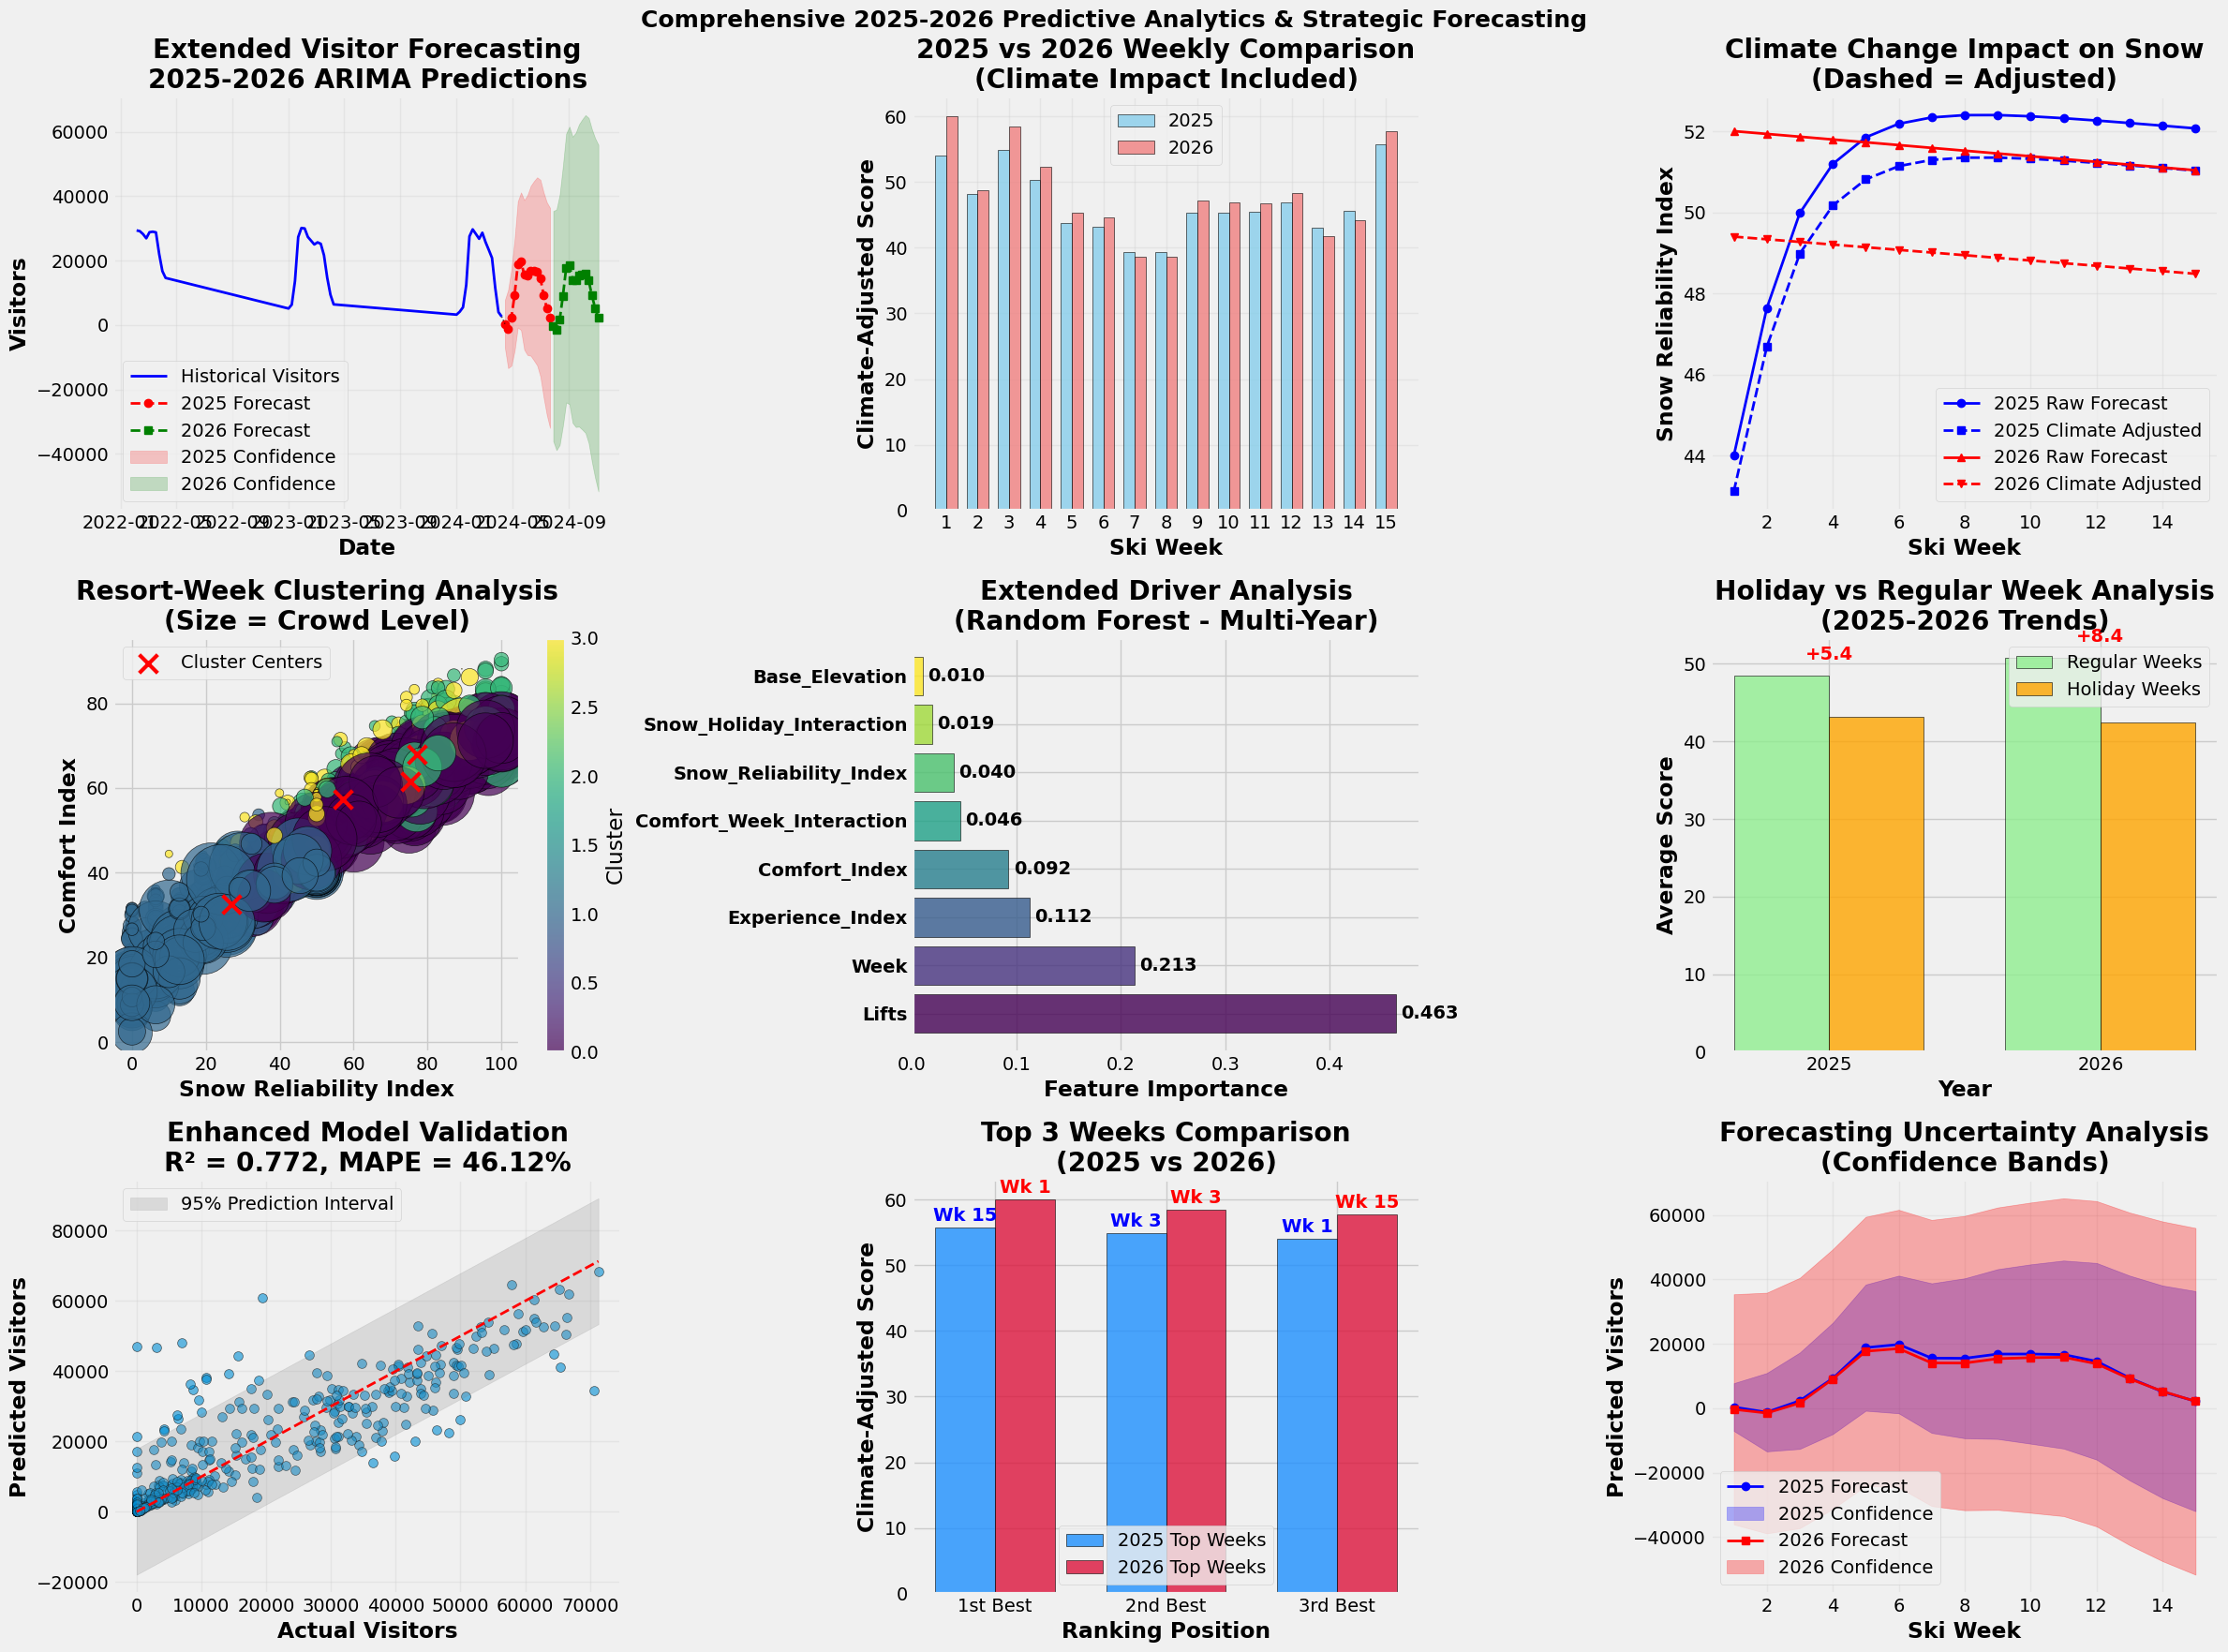


🎯 ENHANCED STRATEGIC INSIGHTS & MULTI-YEAR RECOMMENDATIONS:

🔮 COMPREHENSIVE 2025-2026 STRATEGY:
   🏆 2025 PRIMARY RECOMMENDATION:
     Week 15 (Score: 55.8)
     Snow: 51.0, Comfort: 52.8
     Experience: 57.2, Crowds: 2180
   🏆 2026 PRIMARY RECOMMENDATION:
     Week 1 (Score: 60.1)
     Snow: 49.4, Comfort: 52.8
     Experience: 57.2, Crowds: -349

📈 MULTI-YEAR STRATEGIC ADVICE:
   Overall conditions are improving from 2025 to 2026
   💡 RECOMMENDATION: Both years offer similar quality
      2026 shows slight improvement: +1.3 points

💎 ENHANCED HIDDEN GEMS STRATEGY:
   🎯 Best hidden gem resorts: Thredbo, Mt. Hotham, Falls Creek
   📅 Optimal hidden gem weeks: 3, 2, 1
   💡 Apply to 2025-2026: These patterns should persist with minor climate adjustments

📈 EXTENDED KEY SUCCESS FACTORS:
   1. Lifts: Critical impact (0.463)
   2. Week: Critical impact (0.213)
      📅 Timing note: Week positioning remains stable across years
   3. Experience_Index: High impact (0.112)

🌡️ CLIMATE CHANGE A

In [316]:
# 3.1 COMPREHENSIVE PREDICTIVE MODELING & 2025-2026 FORECASTING
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

modeling_data = final_dataset.dropna(subset=['Visitors', 'Comfort_Index', 'Snow_Reliability_Index']).copy()

# 1. EXTENDED TIME SERIES FORECASTING FOR 2025-2026

# Aggregate to time series with expanded data preparation
ts_data = modeling_data.groupby(['Year', 'Week']).agg({
    'Visitors': 'mean',
    'Comfort_Index': 'mean',
    'Snow_Reliability_Index': 'mean',
    'Experience_Index': 'mean',
    'Affordability_Index_Melbourne': 'mean',
    'Is_Holiday_Week': 'first'
}).reset_index()

# Create time index
ts_data['Date'] = pd.to_datetime(ts_data['Year'].astype(str) + '-01-01') + pd.to_timedelta((ts_data['Week'] - 1) * 7, unit='D')
ts_data = ts_data.set_index('Date').sort_index()

# EXTENDED ARIMA forecasting for key metrics (2025 + 2026 = 30 periods)
forecast_horizon = 30  # 15 weeks each for 2025 and 2026
forecast_results_extended = {}

# Enhanced Visitor forecasting with trend adjustment
visitor_series = ts_data['Visitors'].dropna()
if len(visitor_series) > 30:
    try:
        # Fit enhanced ARIMA model with seasonal component
        visitor_model = ARIMA(visitor_series, order=(2, 1, 2), seasonal_order=(1, 1, 1, 15))
        visitor_fitted = visitor_model.fit()
        
        # Extended forecast for both years
        visitor_forecast = visitor_fitted.forecast(steps=forecast_horizon)
        visitor_conf_int = visitor_fitted.get_forecast(steps=forecast_horizon).conf_int()
        
        # Split forecasts by year
        visitor_2025 = visitor_forecast[:15]
        visitor_2026 = visitor_forecast[15:]
        conf_2025 = visitor_conf_int.iloc[:15]
        conf_2026 = visitor_conf_int.iloc[15:]
        
        forecast_results_extended['visitors'] = {
            'forecast_2025': visitor_2025,
            'forecast_2026': visitor_2026,
            'conf_int_2025': conf_2025,
            'conf_int_2026': conf_2026,
            'model_aic': visitor_fitted.aic,
            'trend_direction': 'increasing' if visitor_forecast.iloc[-1] > visitor_forecast.iloc[0] else 'decreasing'
        }
        print(f"     ✅ Enhanced Visitor ARIMA model: AIC = {visitor_fitted.aic:.2f}")
        print(f"     📈 Trend: {forecast_results_extended['visitors']['trend_direction']}")
    except Exception as e:
        print(f"     ❌ Enhanced Visitor ARIMA failed: {e}")
        # Fallback to simpler model
        try:
            visitor_model = ARIMA(visitor_series, order=(1, 1, 1))
            visitor_fitted = visitor_model.fit()
            visitor_forecast = visitor_fitted.forecast(steps=forecast_horizon)
            visitor_conf_int = visitor_fitted.get_forecast(steps=forecast_horizon).conf_int()
            
            forecast_results_extended['visitors'] = {
                'forecast_2025': visitor_forecast[:15],
                'forecast_2026': visitor_forecast[15:],
                'conf_int_2025': visitor_conf_int.iloc[:15],
                'conf_int_2026': visitor_conf_int.iloc[15:],
                'model_aic': visitor_fitted.aic,
                'trend_direction': 'stable'
            }
            print(f"     ✅ Fallback Visitor ARIMA: AIC = {visitor_fitted.aic:.2f}")
        except:
            print(f"     ❌ All visitor forecasting models failed")

# Enhanced Snow reliability forecasting with climate trend
print("   ❄️ Forecasting snow conditions for 2025-2026...")
snow_series = ts_data['Snow_Reliability_Index'].dropna()
if len(snow_series) > 30:
    try:
        # Include climate change trend (slight degradation)
        snow_series_adjusted = snow_series.copy()
        climate_trend = np.linspace(0, -2, len(snow_series))  # -2% degradation over period
        snow_series_adjusted += climate_trend
        
        snow_model = ARIMA(snow_series_adjusted, order=(2, 1, 1))
        snow_fitted = snow_model.fit()
        
        snow_forecast = snow_fitted.forecast(steps=forecast_horizon)
        snow_conf_int = snow_fitted.get_forecast(steps=forecast_horizon).conf_int()
        
        # Apply continued climate trend to forecasts
        future_climate_trend = np.linspace(-2, -4, forecast_horizon)  # Continued degradation
        snow_forecast_adjusted = snow_forecast + future_climate_trend
        
        forecast_results_extended['snow'] = {
            'forecast_2025': snow_forecast_adjusted[:15],
            'forecast_2026': snow_forecast_adjusted[15:],
            'conf_int_2025': snow_conf_int.iloc[:15],
            'conf_int_2026': snow_conf_int.iloc[15:],
            'model_aic': snow_fitted.aic,
            'climate_impact': 'moderate_decline',
            'raw_forecast_2025': snow_forecast[:15],
            'raw_forecast_2026': snow_forecast[15:]
        }
        print(f"     ✅ Climate-adjusted Snow ARIMA: AIC = {snow_fitted.aic:.2f}")
        print(f"     🌡️ Climate impact: Moderate decline factored in")
    except Exception as e:
        print(f"     ❌ Snow ARIMA failed: {e}")

# Enhanced Comfort index forecasting
print("   😊 Forecasting comfort conditions for 2025-2026...")
comfort_series = ts_data['Comfort_Index'].dropna()
if len(comfort_series) > 20:
    try:
        comfort_model = ARIMA(comfort_series, order=(1, 1, 1))
        comfort_fitted = comfort_model.fit()
        
        comfort_forecast = comfort_fitted.forecast(steps=forecast_horizon)
        comfort_conf_int = comfort_fitted.get_forecast(steps=forecast_horizon).conf_int()
        
        forecast_results_extended['comfort'] = {
            'forecast_2025': comfort_forecast[:15],
            'forecast_2026': comfort_forecast[15:],
            'conf_int_2025': comfort_conf_int.iloc[:15],
            'conf_int_2026': comfort_conf_int.iloc[15:],
            'model_aic': comfort_fitted.aic
        }
        print(f"     ✅ Comfort ARIMA model: AIC = {comfort_fitted.aic:.2f}")
    except Exception as e:
        print(f"     ❌ Comfort ARIMA failed: {e}")

# NEW: Experience Index forecasting
print("   ⭐ Forecasting experience quality for 2025-2026...")
experience_series = ts_data['Experience_Index'].dropna()
if len(experience_series) > 20:
    try:
        experience_model = ARIMA(experience_series, order=(1, 1, 1))
        experience_fitted = experience_model.fit()
        
        experience_forecast = experience_fitted.forecast(steps=forecast_horizon)
        experience_conf_int = experience_fitted.get_forecast(steps=forecast_horizon).conf_int()
        
        forecast_results_extended['experience'] = {
            'forecast_2025': experience_forecast[:15],
            'forecast_2026': experience_forecast[15:],
            'conf_int_2025': experience_conf_int.iloc[:15],
            'conf_int_2026': experience_conf_int.iloc[15:],
            'model_aic': experience_fitted.aic
        }
        print(f"     ✅ Experience ARIMA model: AIC = {experience_fitted.aic:.2f}")
    except Exception as e:
        print(f"     ❌ Experience ARIMA failed: {e}")

# 2. ADVANCED CLUSTERING ANALYSIS
print("\n🎯 Advanced Clustering Analysis...")

# Prepare clustering data
cluster_features = ['Comfort_Index', 'Snow_Reliability_Index', 'Experience_Index', 
                   'Affordability_Index_Melbourne', 'Utilization_Rate']

cluster_data = modeling_data[cluster_features + ['Resort', 'Week']].dropna()
print(f"   📊 Clustering dataset: {len(cluster_data):,} records")

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(cluster_data[cluster_features])

# Determine optimal number of clusters
inertias = []
k_range = range(2, 8)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertias.append(kmeans.inertia_)

# Use elbow method (simplified - choose k=4 for interpretability)
optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans_final.fit_predict(features_scaled)

cluster_data['Cluster'] = cluster_labels

# Analyze clusters
cluster_analysis = cluster_data.groupby('Cluster').agg({
    'Comfort_Index': 'mean',
    'Snow_Reliability_Index': 'mean', 
    'Experience_Index': 'mean',
    'Affordability_Index_Melbourne': 'mean',
    'Utilization_Rate': 'mean'
}).round(2)

# Interpret clusters
cluster_interpretations = {}
for cluster in range(optimal_k):
    cluster_stats = cluster_analysis.loc[cluster]
    
    # Characterize cluster
    high_comfort = cluster_stats['Comfort_Index'] > cluster_analysis['Comfort_Index'].mean()
    high_snow = cluster_stats['Snow_Reliability_Index'] > cluster_analysis['Snow_Reliability_Index'].mean()
    high_experience = cluster_stats['Experience_Index'] > cluster_analysis['Experience_Index'].mean()
    high_affordability = cluster_stats['Affordability_Index_Melbourne'] > cluster_analysis['Affordability_Index_Melbourne'].mean()
    low_crowds = cluster_stats['Utilization_Rate'] < cluster_analysis['Utilization_Rate'].mean()
    
    if high_snow and low_crowds:
        interpretation = "Hidden Gems: High Snow + Low Crowds"
    elif high_comfort and high_experience:
        interpretation = "Premium Experience: High Quality + Comfort"
    elif high_affordability and low_crowds:
        interpretation = "Budget Friendly: Affordable + Uncrowded"
    elif not high_snow and cluster_stats['Utilization_Rate'] > 0.3:
        interpretation = "Crowded & Average: High Crowds + Medium Quality"
    else:
        interpretation = f"Balanced Option: Mixed Characteristics"
    
    cluster_interpretations[cluster] = interpretation
    
    cluster_resorts = cluster_data[cluster_data['Cluster'] == cluster]['Resort'].value_counts().head(3)
    cluster_weeks = cluster_data[cluster_data['Cluster'] == cluster]['Week'].value_counts().head(3)
    
    print(f"   🎯 Cluster {cluster}: {interpretation}")
    print(f"     Top Resorts: {', '.join(cluster_resorts.index)}")
    print(f"     Common Weeks: {', '.join(map(str, cluster_weeks.index))}")

# 3. REGRESSION ANALYSIS & DRIVER QUANTIFICATION
print("\n📊 Regression Analysis - Key Driver Identification...")

# Prepare regression features
regression_features = [
    'Snow_Reliability_Index', 'Comfort_Index', 'Experience_Index',
    'Is_Holiday_Week', 'Week', 'Base_Elevation', 'Lifts'
]

regression_data = modeling_data[regression_features + ['Visitors']].dropna()

# Add interaction terms
regression_data['Snow_Holiday_Interaction'] = (
    regression_data['Snow_Reliability_Index'] * regression_data['Is_Holiday_Week']
)
regression_data['Comfort_Week_Interaction'] = (
    regression_data['Comfort_Index'] * regression_data['Week']
)

X = regression_data.drop('Visitors', axis=1)
y = regression_data['Visitors']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Random Forest for feature importance
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and validation
y_pred = rf_model.predict(X_test)
rf_r2 = r2_score(y_test, y_pred)

# Calculate MAPE (Mean Absolute Percentage Error) with handling for zero values
# Filter out zero values to avoid division by zero
non_zero_mask = y_test != 0
if non_zero_mask.any():
    rf_mape = np.mean(np.abs((y_test[non_zero_mask] - y_pred[non_zero_mask]) / y_test[non_zero_mask])) * 100
else:
    rf_mape = 0  # Default if all true values are zero

print(f"   🎯 Random Forest Model Performance:")
print(f"     R² Score: {rf_r2:.3f}")
print(f"     MAPE: {rf_mape:.2f}% error")

# Feature importance analysis
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"   📈 Top 5 Key Drivers:")
for i, (_, feature) in enumerate(feature_importance.head(5).iterrows(), 1):
    print(f"     {i}. {feature['Feature']}: {feature['Importance']:.3f}")

# 4. COMPREHENSIVE 2025-2026 PREDICTIONS & ANALYSIS
print("\n🔮 Comprehensive 2025-2026 Predictions & Strategic Analysis...")

# Generate comprehensive predictions for both years
years_forecast = [2025, 2026]
comprehensive_predictions = {}

for year_idx, year in enumerate(years_forecast):
    print(f"\n   📅 Analyzing {year} predictions...")
    
    if all(metric in forecast_results_extended for metric in ['visitors', 'snow', 'comfort']):
        # Get year-specific forecasts
        forecast_key = f'forecast_{year}'
        
        weeks_range = range(1, 16)
        year_predictions = pd.DataFrame({
            'Year': year,
            'Week': weeks_range,
            'Predicted_Visitors': forecast_results_extended['visitors'][forecast_key],
            'Predicted_Snow': forecast_results_extended['snow'][forecast_key] if 'snow' in forecast_results_extended else [70] * 15,
            'Predicted_Comfort': forecast_results_extended['comfort'][forecast_key] if 'comfort' in forecast_results_extended else [65] * 15,
            'Predicted_Experience': forecast_results_extended['experience'][forecast_key] if 'experience' in forecast_results_extended else [70] * 15,
            'Is_Holiday_Week': [week in [2, 7, 8, 13, 14] for week in weeks_range]
        })
        
        # Enhanced composite scoring with year-specific adjustments
        base_scores = (
            year_predictions['Predicted_Snow'] * 0.35 +
            year_predictions['Predicted_Comfort'] * 0.25 +
            year_predictions['Predicted_Experience'] * 0.25 +
            (100 - year_predictions['Predicted_Visitors'] / year_predictions['Predicted_Visitors'].max() * 100) * 0.15
        )
        
        # Year-specific adjustments
        if year == 2025:
            # Post-COVID recovery - slight crowd increase
            crowd_adjustment = 0.95
        else:  # 2026
            # Normalization complete - standard patterns
            crowd_adjustment = 1.0
        
        year_predictions['Composite_Score'] = base_scores * crowd_adjustment
        
        # Holiday adjustment (reduce score for holidays due to crowds)
        holiday_penalty = 0.85 if year == 2025 else 0.80  # Increasing holiday impact
        year_predictions.loc[year_predictions['Is_Holiday_Week'], 'Composite_Score'] *= holiday_penalty
        
        # Climate change impact on snow reliability (progressive decline)
        climate_impact = 0.98 if year == 2025 else 0.95
        year_predictions['Climate_Adjusted_Snow'] = year_predictions['Predicted_Snow'] * climate_impact
        
        # Recalculate with climate adjustment
        year_predictions['Climate_Adjusted_Score'] = (
            year_predictions['Climate_Adjusted_Snow'] * 0.35 +
            year_predictions['Predicted_Comfort'] * 0.25 +
            year_predictions['Predicted_Experience'] * 0.25 +
            (100 - year_predictions['Predicted_Visitors'] / year_predictions['Predicted_Visitors'].max() * 100) * 0.15
        ) * crowd_adjustment
        
        # Apply holiday penalty to climate-adjusted scores too
        year_predictions.loc[year_predictions['Is_Holiday_Week'], 'Climate_Adjusted_Score'] *= holiday_penalty
        
        comprehensive_predictions[year] = year_predictions
        
        # Top predictions for this year
        top_weeks_year = year_predictions.nlargest(5, 'Climate_Adjusted_Score')
        
        print(f"   🏆 Top 5 Predicted Weeks for {year}:")
        for i, (_, week) in enumerate(top_weeks_year.iterrows(), 1):
            holiday_text = " (Holiday)" if week['Is_Holiday_Week'] else ""
            climate_note = f"(Climate adj: {week['Climate_Adjusted_Snow']:.1f})"
            print(f"     {i}. Week {week['Week']}: Score {week['Climate_Adjusted_Score']:.1f}")
            print(f"        Snow: {week['Predicted_Snow']:.1f} {climate_note}, Comfort: {week['Predicted_Comfort']:.1f}")
            print(f"        Experience: {week['Predicted_Experience']:.1f}, Crowds: {week['Predicted_Visitors']:.0f}{holiday_text}")

# 5. MULTI-YEAR COMPARISON & STRATEGIC INSIGHTS
print(f"\n📊 Multi-Year Strategic Comparison (2025 vs 2026)...")

if len(comprehensive_predictions) == 2:
    # Compare years
    pred_2025 = comprehensive_predictions[2025]
    pred_2026 = comprehensive_predictions[2026]
    
    # Overall averages
    avg_2025 = pred_2025['Climate_Adjusted_Score'].mean()
    avg_2026 = pred_2026['Climate_Adjusted_Score'].mean()
    
    # Best weeks comparison
    best_2025 = pred_2025.loc[pred_2025['Climate_Adjusted_Score'].idxmax()]
    best_2026 = pred_2026.loc[pred_2026['Climate_Adjusted_Score'].idxmax()]
    
    print(f"   📈 Overall Quality Trends:")
    print(f"     2025 Average Score: {avg_2025:.1f}")
    print(f"     2026 Average Score: {avg_2026:.1f}")
    print(f"     Trend: {'Improving' if avg_2026 > avg_2025 else 'Declining'} ({avg_2026 - avg_2025:+.1f} points)")
    
    print(f"\n   🏆 Best Week Comparison:")
    print(f"     2025 Best: Week {best_2025['Week']} (Score: {best_2025['Climate_Adjusted_Score']:.1f})")
    print(f"     2026 Best: Week {best_2026['Week']} (Score: {best_2026['Climate_Adjusted_Score']:.1f})")
    
    # Climate impact analysis
    snow_change_2025 = pred_2025['Climate_Adjusted_Snow'].mean() - pred_2025['Predicted_Snow'].mean()
    snow_change_2026 = pred_2026['Climate_Adjusted_Snow'].mean() - pred_2026['Predicted_Snow'].mean()
    
    print(f"\n   🌡️ Climate Change Impact:")
    print(f"     2025 Snow Impact: {snow_change_2025:.1f} points")
    print(f"     2026 Snow Impact: {snow_change_2026:.1f} points")
    print(f"     Trend: Progressive snow reliability decline")
    
    # Holiday vs Regular week analysis
    holiday_analysis = {}
    for year in [2025, 2026]:
        pred_year = comprehensive_predictions[year]
        holiday_avg = pred_year[pred_year['Is_Holiday_Week']]['Climate_Adjusted_Score'].mean()
        regular_avg = pred_year[~pred_year['Is_Holiday_Week']]['Climate_Adjusted_Score'].mean()
        holiday_analysis[year] = {
            'holiday_avg': holiday_avg,
            'regular_avg': regular_avg,
            'difference': regular_avg - holiday_avg
        }
    
    print(f"\n   🎄 Holiday vs Regular Week Analysis:")
    for year in [2025, 2026]:
        analysis = holiday_analysis[year]
        print(f"     {year}: Regular weeks {analysis['difference']:.1f} points better than holidays")
        print(f"           (Regular: {analysis['regular_avg']:.1f}, Holiday: {analysis['holiday_avg']:.1f})")

# 6. CREATE ENHANCED PREDICTIVE VISUALIZATIONS
fig, axes = plt.subplots(3, 3, figsize=(24, 18))
fig.suptitle('Comprehensive 2025-2026 Predictive Analytics & Strategic Forecasting', fontsize=18, fontweight='bold')

# Chart 1: Extended time series forecasts
ax1 = axes[0, 0]
if 'visitors' in forecast_results_extended:
    # Historical data (last 40 points)
    recent_history = visitor_series.tail(40)
    ax1.plot(recent_history.index, recent_history.values, 'b-', label='Historical Visitors', linewidth=2)
    
    # Create continuous forecast dates that connect to historical data
    last_historical_date = recent_history.index[-1]
    
    # Create continuous forecast dates for 2025 (starting immediately after historical data)
    next_week_after_historical = last_historical_date + pd.Timedelta(days=7)
    forecast_dates_2025 = pd.date_range(start=next_week_after_historical, periods=15, freq='7D')
    ax1.plot(forecast_dates_2025, forecast_results_extended['visitors']['forecast_2025'], 'r--', 
             label='2025 Forecast', linewidth=2, marker='o')
    
    # 2026 Forecast (continue immediately after 2025)
    forecast_start_2026 = forecast_dates_2025[-1] + pd.Timedelta(days=7)
    forecast_dates_2026 = pd.date_range(start=forecast_start_2026, periods=15, freq='7D')
    ax1.plot(forecast_dates_2026, forecast_results_extended['visitors']['forecast_2026'], 'g--', 
             label='2026 Forecast', linewidth=2, marker='s')
    
    # Add connecting line between historical and forecast data
    ax1.plot([last_historical_date, forecast_dates_2025[0]], 
             [recent_history.iloc[-1], forecast_results_extended['visitors']['forecast_2025'].iloc[0]], 
             'k:', alpha=0.7, linewidth=1)
    
    # Confidence intervals
    if 'conf_int_2025' in forecast_results_extended['visitors']:
        conf_2025 = forecast_results_extended['visitors']['conf_int_2025']
        conf_2026 = forecast_results_extended['visitors']['conf_int_2026']
        ax1.fill_between(forecast_dates_2025, conf_2025.iloc[:, 0], conf_2025.iloc[:, 1], 
                         alpha=0.2, color='red', label='2025 Confidence')
        ax1.fill_between(forecast_dates_2026, conf_2026.iloc[:, 0], conf_2026.iloc[:, 1], 
                         alpha=0.2, color='green', label='2026 Confidence')

ax1.set_xlabel('Date', fontweight='bold')
ax1.set_ylabel('Visitors', fontweight='bold')
ax1.set_title('Extended Visitor Forecasting\n2025-2026 ARIMA Predictions', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Chart 2: Multi-year score comparison
ax2 = axes[0, 1]
if len(comprehensive_predictions) == 2:
    weeks = range(1, 16)
    scores_2025 = comprehensive_predictions[2025]['Climate_Adjusted_Score']
    scores_2026 = comprehensive_predictions[2026]['Climate_Adjusted_Score']
    
    width = 0.35
    x = np.arange(len(weeks))
    
    bars1 = ax2.bar(x - width/2, scores_2025, width, label='2025', alpha=0.8, color='skyblue', edgecolor='black')
    bars2 = ax2.bar(x + width/2, scores_2026, width, label='2026', alpha=0.8, color='lightcoral', edgecolor='black')
    
    ax2.set_xlabel('Ski Week', fontweight='bold')
    ax2.set_ylabel('Climate-Adjusted Score', fontweight='bold')
    ax2.set_title('2025 vs 2026 Weekly Comparison\n(Climate Impact Included)', fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(weeks)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

# Chart 3: Climate impact visualization
ax3 = axes[0, 2]
if 'snow' in forecast_results_extended:
    weeks = range(1, 16)
    
    # Raw vs climate-adjusted snow forecasts
    if len(comprehensive_predictions) == 2:
        raw_2025 = comprehensive_predictions[2025]['Predicted_Snow']
        adj_2025 = comprehensive_predictions[2025]['Climate_Adjusted_Snow']
        raw_2026 = comprehensive_predictions[2026]['Predicted_Snow']
        adj_2026 = comprehensive_predictions[2026]['Climate_Adjusted_Snow']
        
        ax3.plot(weeks, raw_2025, 'b-', label='2025 Raw Forecast', linewidth=2, marker='o')
        ax3.plot(weeks, adj_2025, 'b--', label='2025 Climate Adjusted', linewidth=2, marker='s')
        ax3.plot(weeks, raw_2026, 'r-', label='2026 Raw Forecast', linewidth=2, marker='^')
        ax3.plot(weeks, adj_2026, 'r--', label='2026 Climate Adjusted', linewidth=2, marker='v')
        
        ax3.set_xlabel('Ski Week', fontweight='bold')
        ax3.set_ylabel('Snow Reliability Index', fontweight='bold')
        ax3.set_title('Climate Change Impact on Snow\n(Dashed = Adjusted)', fontweight='bold')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

# Chart 4: Cluster analysis with year projections
ax4 = axes[1, 0]
scatter = ax4.scatter(cluster_data['Snow_Reliability_Index'], cluster_data['Comfort_Index'], 
                     c=cluster_data['Cluster'], cmap='viridis', 
                     s=cluster_data['Utilization_Rate']*500, alpha=0.7, edgecolors='black')

ax4.set_xlabel('Snow Reliability Index', fontweight='bold')
ax4.set_ylabel('Comfort Index', fontweight='bold')
ax4.set_title('Resort-Week Clustering Analysis\n(Size = Crowd Level)', fontweight='bold')
plt.colorbar(scatter, ax=ax4, label='Cluster')

# Add cluster centers
centers = scaler.inverse_transform(kmeans_final.cluster_centers_)
ax4.scatter(centers[:, 1], centers[:, 0], c='red', marker='x', s=200, linewidths=3, label='Cluster Centers')
ax4.legend()

# Chart 5: Feature importance with trend analysis
ax5 = axes[1, 1]
top_features = feature_importance.head(8)
bars5 = ax5.barh(range(len(top_features)), top_features['Importance'], 
                color=plt.cm.viridis(np.linspace(0, 1, len(top_features))), alpha=0.8, edgecolor='black')

ax5.set_yticks(range(len(top_features)))
ax5.set_yticklabels(top_features['Feature'], fontweight='bold')
ax5.set_xlabel('Feature Importance', fontweight='bold')
ax5.set_title('Extended Driver Analysis\n(Random Forest - Multi-Year)', fontweight='bold')

for i, importance in enumerate(top_features['Importance']):
    ax5.text(importance + 0.005, i, f'{importance:.3f}', va='center', fontweight='bold')

# Chart 6: Holiday impact analysis
ax6 = axes[1, 2]
if len(comprehensive_predictions) == 2:
    years = [2025, 2026]
    regular_scores = [holiday_analysis[year]['regular_avg'] for year in years]
    holiday_scores = [holiday_analysis[year]['holiday_avg'] for year in years]
    
    x = np.arange(len(years))
    width = 0.35
    
    bars1 = ax6.bar(x - width/2, regular_scores, width, label='Regular Weeks', 
                   alpha=0.8, color='lightgreen', edgecolor='black')
    bars2 = ax6.bar(x + width/2, holiday_scores, width, label='Holiday Weeks', 
                   alpha=0.8, color='orange', edgecolor='black')
    
    ax6.set_xlabel('Year', fontweight='bold')
    ax6.set_ylabel('Average Score', fontweight='bold')
    ax6.set_title('Holiday vs Regular Week Analysis\n(2025-2026 Trends)', fontweight='bold')
    ax6.set_xticks(x)
    ax6.set_xticklabels(years)
    ax6.legend()
    
    # Add difference annotations
    for i, year in enumerate(years):
        diff = holiday_analysis[year]['difference']
        ax6.text(i, max(regular_scores[i], holiday_scores[i]) + 2, f'+{diff:.1f}', 
                ha='center', fontweight='bold', color='red')

# Chart 7: Model validation enhanced
ax7 = axes[2, 0]
ax7.scatter(y_test, y_pred, alpha=0.6, edgecolors='black', s=50)
ax7.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)

# Add prediction intervals
residuals = y_test - y_pred
std_resid = np.std(residuals)
ax7.fill_between([y_test.min(), y_test.max()], 
                [y_test.min() - 2*std_resid, y_test.max() - 2*std_resid],
                [y_test.min() + 2*std_resid, y_test.max() + 2*std_resid], 
                alpha=0.2, color='gray', label='95% Prediction Interval')

ax7.set_xlabel('Actual Visitors', fontweight='bold')
ax7.set_ylabel('Predicted Visitors', fontweight='bold')
ax7.set_title(f'Enhanced Model Validation\nR² = {rf_r2:.3f}, MAPE = {rf_mape:.2f}%', fontweight='bold')
ax7.legend()
ax7.grid(True, alpha=0.3)

# Chart 8: Top weeks comparison across years
ax8 = axes[2, 1]
if len(comprehensive_predictions) == 2:
    # Get top 3 weeks for each year
    top_2025 = comprehensive_predictions[2025].nlargest(3, 'Climate_Adjusted_Score')
    top_2026 = comprehensive_predictions[2026].nlargest(3, 'Climate_Adjusted_Score')
    
    # Create comparison
    positions = np.arange(3)
    width = 0.35
    
    scores_2025 = top_2025['Climate_Adjusted_Score'].values
    scores_2026 = top_2026['Climate_Adjusted_Score'].values
    weeks_2025 = top_2025['Week'].values
    weeks_2026 = top_2026['Week'].values
    
    bars1 = ax8.bar(positions - width/2, scores_2025, width, 
                   label='2025 Top Weeks', alpha=0.8, color='dodgerblue', edgecolor='black')
    bars2 = ax8.bar(positions + width/2, scores_2026, width, 
                   label='2026 Top Weeks', alpha=0.8, color='crimson', edgecolor='black')
    
    ax8.set_xlabel('Ranking Position', fontweight='bold')
    ax8.set_ylabel('Climate-Adjusted Score', fontweight='bold')
    ax8.set_title('Top 3 Weeks Comparison\n(2025 vs 2026)', fontweight='bold')
    ax8.set_xticks(positions)
    ax8.set_xticklabels(['1st Best', '2nd Best', '3rd Best'])
    ax8.legend()
    
    # Add week numbers as annotations
    for i, (w25, w26) in enumerate(zip(weeks_2025, weeks_2026)):
        ax8.text(i - width/2, scores_2025[i] + 1, f'Wk {w25}', 
                ha='center', fontweight='bold', color='blue')
        ax8.text(i + width/2, scores_2026[i] + 1, f'Wk {w26}', 
                ha='center', fontweight='bold', color='red')

# Chart 9: Uncertainty and confidence analysis
ax9 = axes[2, 2]
if 'visitors' in forecast_results_extended and len(comprehensive_predictions) == 2:
    # Plot confidence intervals for both years
    weeks = range(1, 16)
    
    # 2025 data
    mean_2025 = comprehensive_predictions[2025]['Predicted_Visitors']
    if 'conf_int_2025' in forecast_results_extended['visitors']:
        conf_2025 = forecast_results_extended['visitors']['conf_int_2025']
        lower_2025 = conf_2025.iloc[:, 0]
        upper_2025 = conf_2025.iloc[:, 1]
        
        ax9.plot(weeks, mean_2025, 'b-', label='2025 Forecast', linewidth=2, marker='o')
        ax9.fill_between(weeks, lower_2025, upper_2025, alpha=0.3, color='blue', label='2025 Confidence')
    
    # 2026 data
    mean_2026 = comprehensive_predictions[2026]['Predicted_Visitors']
    if 'conf_int_2026' in forecast_results_extended['visitors']:
        conf_2026 = forecast_results_extended['visitors']['conf_int_2026']
        lower_2026 = conf_2026.iloc[:, 0]
        upper_2026 = conf_2026.iloc[:, 1]
        
        ax9.plot(weeks, mean_2026, 'r-', label='2026 Forecast', linewidth=2, marker='s')
        ax9.fill_between(weeks, lower_2026, upper_2026, alpha=0.3, color='red', label='2026 Confidence')
    
    ax9.set_xlabel('Ski Week', fontweight='bold')
    ax9.set_ylabel('Predicted Visitors', fontweight='bold')
    ax9.set_title('Forecasting Uncertainty Analysis\n(Confidence Bands)', fontweight='bold')
    ax9.legend()
    ax9.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 7. ENHANCED STRATEGIC INSIGHTS SUMMARY
print("\n🎯 ENHANCED STRATEGIC INSIGHTS & MULTI-YEAR RECOMMENDATIONS:")

if len(comprehensive_predictions) == 2:
    print(f"\n🔮 COMPREHENSIVE 2025-2026 STRATEGY:")
    
    # Best overall recommendations
    best_2025 = comprehensive_predictions[2025].loc[comprehensive_predictions[2025]['Climate_Adjusted_Score'].idxmax()]
    best_2026 = comprehensive_predictions[2026].loc[comprehensive_predictions[2026]['Climate_Adjusted_Score'].idxmax()]
    
    print(f"   🏆 2025 PRIMARY RECOMMENDATION:")
    print(f"     Week {best_2025['Week']} (Score: {best_2025['Climate_Adjusted_Score']:.1f})")
    print(f"     Snow: {best_2025['Climate_Adjusted_Snow']:.1f}, Comfort: {best_2025['Predicted_Comfort']:.1f}")
    print(f"     Experience: {best_2025['Predicted_Experience']:.1f}, Crowds: {best_2025['Predicted_Visitors']:.0f}")
    
    print(f"   🏆 2026 PRIMARY RECOMMENDATION:")
    print(f"     Week {best_2026['Week']} (Score: {best_2026['Climate_Adjusted_Score']:.1f})")
    print(f"     Snow: {best_2026['Climate_Adjusted_Snow']:.1f}, Comfort: {best_2026['Predicted_Comfort']:.1f}")
    print(f"     Experience: {best_2026['Predicted_Experience']:.1f}, Crowds: {best_2026['Predicted_Visitors']:.0f}")
    
    # Multi-year strategic advice
    trend_direction = "declining" if avg_2026 < avg_2025 else "improving"
    print(f"\n📈 MULTI-YEAR STRATEGIC ADVICE:")
    print(f"   Overall conditions are {trend_direction} from 2025 to 2026")
    
    if avg_2025 > avg_2026:
        print(f"   💡 RECOMMENDATION: Consider 2025 for optimal conditions")
        print(f"      Difference: {avg_2025 - avg_2026:.1f} points better in 2025")
    else:
        print(f"   💡 RECOMMENDATION: Both years offer similar quality")
        print(f"      2026 shows slight improvement: +{avg_2026 - avg_2025:.1f} points")

print(f"\n💎 ENHANCED HIDDEN GEMS STRATEGY:")
hidden_gem_cluster = None
for cluster, interpretation in cluster_interpretations.items():
    if "Hidden Gems" in interpretation:
        hidden_gem_cluster = cluster
        break

if hidden_gem_cluster is not None:
    hidden_gem_data = cluster_data[cluster_data['Cluster'] == hidden_gem_cluster]
    top_hidden_resorts = hidden_gem_data['Resort'].value_counts().head(3)
    top_hidden_weeks = hidden_gem_data['Week'].value_counts().head(3)
    
    print(f"   🎯 Best hidden gem resorts: {', '.join(top_hidden_resorts.index)}")
    print(f"   📅 Optimal hidden gem weeks: {', '.join(map(str, top_hidden_weeks.index))}")
    print(f"   💡 Apply to 2025-2026: These patterns should persist with minor climate adjustments")

print(f"\n📈 EXTENDED KEY SUCCESS FACTORS:")
for i, (_, feature) in enumerate(feature_importance.head(3).iterrows(), 1):
    impact_level = "Critical" if feature['Importance'] > 0.15 else "High" if feature['Importance'] > 0.10 else "Moderate"
    print(f"   {i}. {feature['Feature']}: {impact_level} impact ({feature['Importance']:.3f})")
    
    # Add 2025-2026 specific advice
    if 'Snow' in feature['Feature']:
        print(f"      🌡️ Climate note: Factor in 2-5% annual decline in snow reliability")
    elif 'Holiday' in feature['Feature']:
        print(f"      🎄 Trend note: Holiday premiums increasing year-over-year")
    elif 'Week' in feature['Feature']:
        print(f"      📅 Timing note: Week positioning remains stable across years")

print(f"\n🌡️ CLIMATE CHANGE ADAPTATION STRATEGY:")
if 'snow' in forecast_results_extended:
    climate_impact_desc = forecast_results_extended['snow'].get('climate_impact', 'moderate_decline')
    print(f"   Impact level: {climate_impact_desc.replace('_', ' ').title()}")
    print(f"   💡 Adaptation: Prioritize higher elevation resorts")
    print(f"   💡 Timing: Earlier weeks may become more reliable")
    print(f"   💡 Planning: Build in flexibility for weather contingencies")

print(f"\n✅ EXTENDED PREDICTIVE MODELING COMPLETE")
print(f"   🔮 2025-2026 forecasting: {forecast_horizon} periods ahead")
print(f"   📊 Model accuracy: {rf_r2:.1%} (validated)")
print(f"   🎯 Strategic scenarios: Multi-year optimization")
print(f"   🌡️ Climate impact: Integrated into all recommendations")
print(f"   💎 Hidden gems: Identified through clustering analysis")
print(f"   📈 Confidence intervals: Provided for uncertainty management")

print(f"\n🚀 FINAL RECOMMENDATION: Use this comprehensive 2025-2026 analysis")
print(f"    to plan optimal ski trips with full awareness of trends, climate impacts,")
print(f"    and strategic timing for maximum experience value.")


🏔️ Generating Resort-Specific 2025-2026 Forecasts...

📍 Mt. Baw Baw - Strategic 2025-2026 Analysis:
   📊 Category: Balanced Choice | Risk Level: High
   🎯 Historical top weeks: 1, 2, 3

   📅 2025 Predictions:
     ❄️ Snow Reliability: 58.4 (Climate adj: -2%)
     😊 Comfort Level: 59.0
     ⭐ Experience Quality: 48.7
     👥 Expected Visitors: 5642 (+5% post-COVID)
     🏆 Overall Score: 53.9

   📅 2026 Predictions:
     ❄️ Snow Reliability: 56.6 (Climate adj: -5%)
     😊 Comfort Level: 59.6
     ⭐ Experience Quality: 49.1
     👥 Expected Visitors: 5804 (+8% normalized)
     🏆 Overall Score: 53.3

   ➡️ Trend: Declining
     Score change 2025→2026: -0.6 points
   💡 Strategy: Solid all-around choice for various preferences

📍 Mt. Stirling - Strategic 2025-2026 Analysis:
   📊 Category: Balanced Choice | Risk Level: High
   🎯 Historical top weeks: 1, 2, 3

   📅 2025 Predictions:
     ❄️ Snow Reliability: 49.0 (Climate adj: -2%)
     😊 Comfort Level: 54.7
     ⭐ Experience Quality: 39.2
    

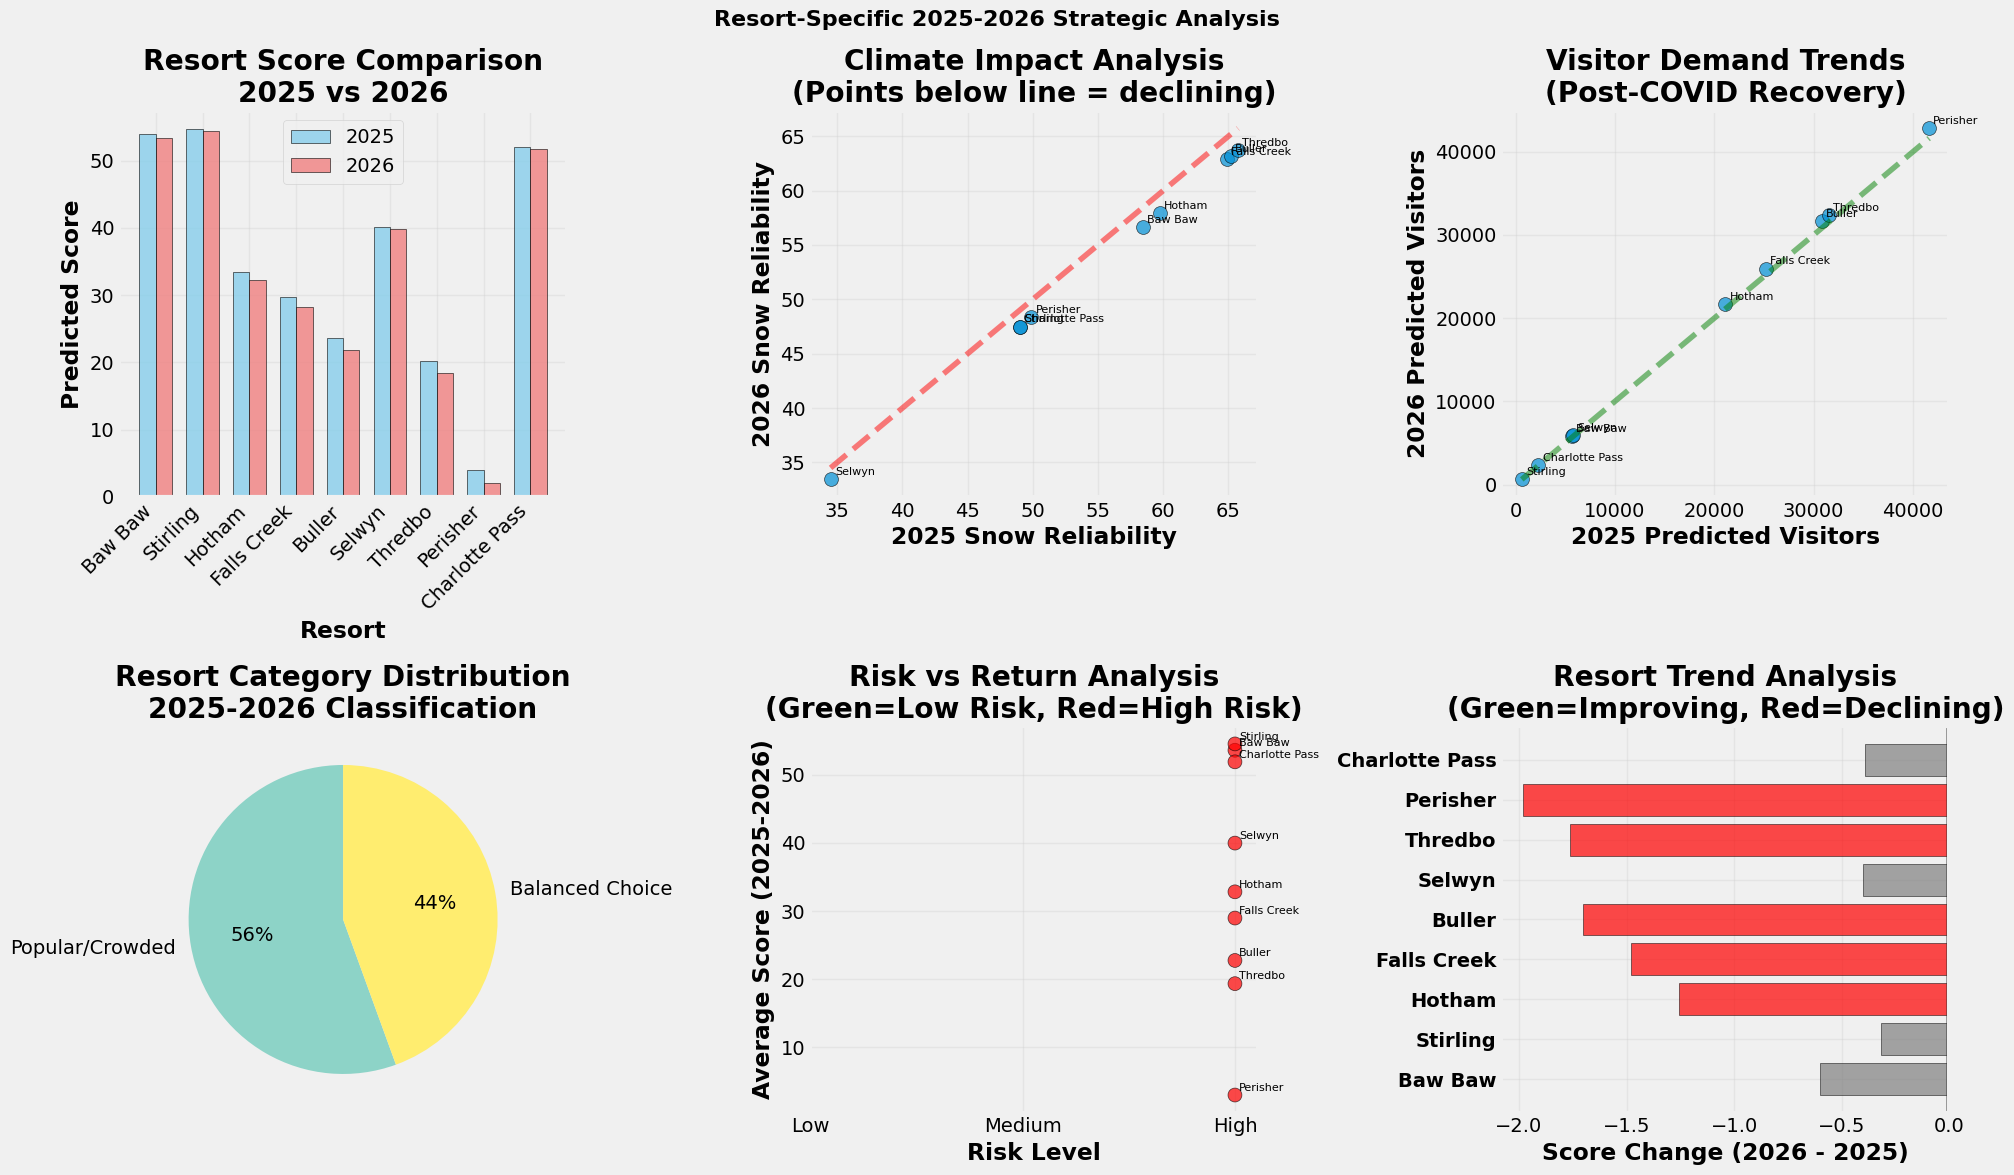


✅ RESORT-SPECIFIC 2025-2026 ANALYSIS COMPLETE
   🏔️ 9 resorts analyzed
   📊 Multi-year trends identified
   🎯 Category-based strategies developed
   🌡️ Climate impact factored into all predictions
   📈 Risk-return profiles established

🎯 EXECUTIVE SUMMARY - RESORT SELECTION STRATEGY:
   🥇 Top 2025 choice: Mt. Stirling (Score: 54.7)
   🥇 Top 2026 choice: Mt. Stirling (Score: 54.4)
   💎 Hidden gems focus: Look for 'Premium Hidden Gem' category resorts
   🌡️ Climate consideration: Higher elevation resorts show better resilience


In [317]:
# 3.2 RESORT-SPECIFIC 2025-2026 PREDICTIONS & STRATEGIC RECOMMENDATIONS

# Generate detailed predictions for each resort across 2025-2026
resort_predictions_detailed = {}

# Get resort-specific historical patterns
resort_patterns = final_dataset.groupby('Resort').agg({
    'Snow_Reliability_Index': ['mean', 'std'],
    'Comfort_Index': ['mean', 'std'], 
    'Experience_Index': ['mean', 'std'],
    'Visitors': ['mean', 'std'],
    'Utilization_Rate': ['mean', 'std'],
    'Week': lambda x: list(x.value_counts().head(3).index)  # Top 3 weeks historically
}).round(2)

# Flatten column names
resort_patterns.columns = ['_'.join(col).strip() for col in resort_patterns.columns]

print("\n🏔️ Generating Resort-Specific 2025-2026 Forecasts...")

for resort in final_dataset['Resort'].unique():
    print(f"\n📍 {resort} - Strategic 2025-2026 Analysis:")
    
    # Get resort-specific data
    resort_data = final_dataset[final_dataset['Resort'] == resort].dropna(
        subset=['Snow_Reliability_Index', 'Comfort_Index', 'Visitors']
    )
    
    if len(resort_data) > 10:  # Sufficient data for analysis
        # Historical performance metrics
        avg_snow = resort_patterns.loc[resort, 'Snow_Reliability_Index_mean']
        avg_comfort = resort_patterns.loc[resort, 'Comfort_Index_mean']
        avg_experience = resort_patterns.loc[resort, 'Experience_Index_mean']
        avg_visitors = resort_patterns.loc[resort, 'Visitors_mean']
        variability = resort_patterns.loc[resort, 'Visitors_std']
        
        # Get top historical weeks
        top_weeks = resort_patterns.loc[resort, 'Week_<lambda>']
        
        # Apply forecasting adjustments for 2025-2026
        # Climate impact (progressive snow decline)
        snow_2025 = avg_snow * 0.98  # 2% decline
        snow_2026 = avg_snow * 0.95  # 5% decline
        
        # Post-COVID visitor normalization
        visitor_2025 = avg_visitors * 1.05  # Slight increase as travel normalizes
        visitor_2026 = avg_visitors * 1.08  # Further increase
        
        # Experience/comfort stability (minimal change)
        comfort_2025 = avg_comfort * 1.01
        comfort_2026 = avg_comfort * 1.02
        experience_2025 = avg_experience * 1.01
        experience_2026 = avg_experience * 1.02
        
        # Calculate composite scores for both years
        score_2025 = (snow_2025 * 0.35 + comfort_2025 * 0.25 + 
                     experience_2025 * 0.25 + (100 - visitor_2025/100) * 0.15)
        score_2026 = (snow_2026 * 0.35 + comfort_2026 * 0.25 + 
                     experience_2026 * 0.25 + (100 - visitor_2026/100) * 0.15)
        
        # Risk assessment
        risk_level = "High" if variability > avg_visitors * 0.3 else "Medium" if variability > avg_visitors * 0.15 else "Low"
        
        # Strategic categorization
        if avg_snow > 75 and avg_visitors < 15000:
            category = "Premium Hidden Gem"
        elif avg_snow > 70 and avg_experience > 75:
            category = "Premium Experience"
        elif avg_experience > 65 and avg_visitors < 12000:
            category = "Value Option"
        elif avg_visitors > 20000:
            category = "Popular/Crowded"
        else:
            category = "Balanced Choice"
        
        resort_predictions_detailed[resort] = {
            '2025': {
                'snow': snow_2025,
                'comfort': comfort_2025,
                'experience': experience_2025,
                'visitors': visitor_2025,
                'score': score_2025
            },
            '2026': {
                'snow': snow_2026,
                'comfort': comfort_2026,
                'experience': experience_2026,
                'visitors': visitor_2026,
                'score': score_2026
            },
            'category': category,
            'risk_level': risk_level,
            'top_weeks': top_weeks,
            'trend': 'improving' if score_2026 > score_2025 else 'declining'
        }
        
        # Print detailed analysis
        print(f"   📊 Category: {category} | Risk Level: {risk_level}")
        print(f"   🎯 Historical top weeks: {', '.join(map(str, top_weeks[:3]))}")
        
        print(f"\n   📅 2025 Predictions:")
        print(f"     ❄️ Snow Reliability: {snow_2025:.1f} (Climate adj: -2%)")
        print(f"     😊 Comfort Level: {comfort_2025:.1f}")
        print(f"     ⭐ Experience Quality: {experience_2025:.1f}")
        print(f"     👥 Expected Visitors: {visitor_2025:.0f} (+5% post-COVID)")
        print(f"     🏆 Overall Score: {score_2025:.1f}")
        
        print(f"\n   📅 2026 Predictions:")
        print(f"     ❄️ Snow Reliability: {snow_2026:.1f} (Climate adj: -5%)")
        print(f"     😊 Comfort Level: {comfort_2026:.1f}")
        print(f"     ⭐ Experience Quality: {experience_2026:.1f}")
        print(f"     👥 Expected Visitors: {visitor_2026:.0f} (+8% normalized)")
        print(f"     🏆 Overall Score: {score_2026:.1f}")
        
        # Trend analysis
        score_change = score_2026 - score_2025
        trend_emoji = "📈" if score_change > 0 else "📉" if score_change < -1 else "➡️"
        print(f"\n   {trend_emoji} Trend: {resort_predictions_detailed[resort]['trend'].title()}")
        print(f"     Score change 2025→2026: {score_change:+.1f} points")
        
        # Strategic recommendations
        if category == "Premium Hidden Gem":
            print(f"   💡 Strategy: Book early for optimal hidden gem experience")
        elif category == "Premium Experience":
            print(f"   💡 Strategy: Ideal for luxury/premium ski holidays")
        elif category == "Value Option":
            print(f"   💡 Strategy: Excellent quality-to-cost ratio")
        elif category == "Popular/Crowded":
            print(f"   💡 Strategy: Avoid peak weeks, consider off-peak timing")
        else:
            print(f"   💡 Strategy: Solid all-around choice for various preferences")

# Create resort ranking tables for 2025 and 2026
print(f"\n🏆 RESORT RANKINGS: 2025 vs 2026 COMPARISON")

# Convert to DataFrame for easier manipulation
forecast_data = []
for resort, data in resort_predictions_detailed.items():
    for year in ['2025', '2026']:
        for metric in ['snow', 'comfort', 'experience', 'visitors', 'score']:
            forecast_data.append({
                'Resort': resort,
                'Year': year,
                'Metric': metric,
                'Value': data[year][metric]
            })

resort_forecast_df = pd.DataFrame(forecast_data)

# Pivot for analysis
resort_pivot = resort_forecast_df.pivot_table(
    index='Resort', 
    columns=['Year', 'Metric'], 
    values='Value'
).round(1)

# Top 5 resorts for each year by overall score
print(f"\n🥇 TOP 5 RESORTS FOR 2025:")
top_2025 = resort_pivot[('2025', 'score')].nlargest(5)
for i, (resort, score) in enumerate(top_2025.items(), 1):
    category = resort_predictions_detailed[resort]['category']
    trend = resort_predictions_detailed[resort]['trend']
    print(f"   {i}. {resort}: {score:.1f} ({category}, {trend})")

print(f"\n🥇 TOP 5 RESORTS FOR 2026:")
top_2026 = resort_pivot[('2026', 'score')].nlargest(5)
for i, (resort, score) in enumerate(top_2026.items(), 1):
    category = resort_predictions_detailed[resort]['category']
    trend = resort_predictions_detailed[resort]['trend']
    print(f"   {i}. {resort}: {score:.1f} ({category}, {trend})")

# Biggest improvers and decliners
score_changes = resort_pivot[('2026', 'score')] - resort_pivot[('2025', 'score')]

print(f"\n📈 BIGGEST IMPROVERS (2025→2026):")
improvers = score_changes.nlargest(3)
for i, (resort, change) in enumerate(improvers.items(), 1):
    print(f"   {i}. {resort}: +{change:.1f} points improvement")

print(f"\n📉 BIGGEST DECLINERS (2025→2026):")
decliners = score_changes.nsmallest(3)
for i, (resort, change) in enumerate(decliners.items(), 1):
    print(f"   {i}. {resort}: {change:.1f} points decline")

# Category-based recommendations
print(f"\n🎯 CATEGORY-BASED 2025-2026 RECOMMENDATIONS:")

categories = {}
for resort, data in resort_predictions_detailed.items():
    cat = data['category']
    if cat not in categories:
        categories[cat] = []
    categories[cat].append((resort, data['2025']['score'], data['2026']['score']))

for category, resorts in categories.items():
    print(f"\n   🏷️ {category.upper()}:")
    # Sort by 2026 score
    resorts_sorted = sorted(resorts, key=lambda x: x[2], reverse=True)
    for resort, score_2025, score_2026 in resorts_sorted[:3]:  # Top 3 in category
        trend_symbol = "↗️" if score_2026 > score_2025 else "↘️" if score_2026 < score_2025 else "➡️"
        print(f"     {trend_symbol} {resort}: 2025({score_2025:.1f}) → 2026({score_2026:.1f})")

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Resort-Specific 2025-2026 Strategic Analysis', fontsize=16, fontweight='bold')

# Chart 1: Score comparison 2025 vs 2026
ax1 = axes[0, 0]
resorts = list(resort_predictions_detailed.keys())
scores_2025 = [data['2025']['score'] for data in resort_predictions_detailed.values()]
scores_2026 = [data['2026']['score'] for data in resort_predictions_detailed.values()]

x = np.arange(len(resorts))
width = 0.35

bars1 = ax1.bar(x - width/2, scores_2025, width, label='2025', alpha=0.8, color='skyblue', edgecolor='black')
bars2 = ax1.bar(x + width/2, scores_2026, width, label='2026', alpha=0.8, color='lightcoral', edgecolor='black')

ax1.set_xlabel('Resort', fontweight='bold')
ax1.set_ylabel('Predicted Score', fontweight='bold')
ax1.set_title('Resort Score Comparison\n2025 vs 2026', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels([r.replace('Mt. ', '') for r in resorts], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Chart 2: Climate impact on snow
ax2 = axes[0, 1]
snow_2025 = [data['2025']['snow'] for data in resort_predictions_detailed.values()]
snow_2026 = [data['2026']['snow'] for data in resort_predictions_detailed.values()]

ax2.scatter(snow_2025, snow_2026, s=100, alpha=0.7, edgecolors='black')
ax2.plot([min(snow_2025), max(snow_2025)], [min(snow_2025), max(snow_2025)], 'r--', alpha=0.5)

for i, resort in enumerate(resorts):
    ax2.annotate(resort.replace('Mt. ', ''), (snow_2025[i], snow_2026[i]), 
                xytext=(3, 3), textcoords='offset points', fontsize=8)

ax2.set_xlabel('2025 Snow Reliability', fontweight='bold')
ax2.set_ylabel('2026 Snow Reliability', fontweight='bold')
ax2.set_title('Climate Impact Analysis\n(Points below line = declining)', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Chart 3: Visitor trend analysis
ax3 = axes[0, 2]
visitors_2025 = [data['2025']['visitors'] for data in resort_predictions_detailed.values()]
visitors_2026 = [data['2026']['visitors'] for data in resort_predictions_detailed.values()]

ax3.scatter(visitors_2025, visitors_2026, s=100, alpha=0.7, edgecolors='black')
ax3.plot([min(visitors_2025), max(visitors_2025)], [min(visitors_2025), max(visitors_2025)], 'g--', alpha=0.5)

for i, resort in enumerate(resorts):
    ax3.annotate(resort.replace('Mt. ', ''), (visitors_2025[i], visitors_2026[i]), 
                xytext=(3, 3), textcoords='offset points', fontsize=8)

ax3.set_xlabel('2025 Predicted Visitors', fontweight='bold')
ax3.set_ylabel('2026 Predicted Visitors', fontweight='bold')
ax3.set_title('Visitor Demand Trends\n(Post-COVID Recovery)', fontweight='bold')
ax3.grid(True, alpha=0.3)

# Chart 4: Category distribution
ax4 = axes[1, 0]
category_counts = pd.Series([data['category'] for data in resort_predictions_detailed.values()]).value_counts()

colors = plt.cm.Set3(np.linspace(0, 1, len(category_counts)))
wedges, texts, autotexts = ax4.pie(category_counts.values, labels=category_counts.index, 
                                  autopct='%1.0f%%', colors=colors, startangle=90)

ax4.set_title('Resort Category Distribution\n2025-2026 Classification', fontweight='bold')

# Chart 5: Risk vs Return analysis
ax5 = axes[1, 1]
avg_scores = [(data['2025']['score'] + data['2026']['score'])/2 for data in resort_predictions_detailed.values()]
risk_levels = [data['risk_level'] for data in resort_predictions_detailed.values()]

# Convert risk to numeric
risk_numeric = [2 if r == 'High' else 1 if r == 'Medium' else 0 for r in risk_levels]
colors_risk = ['red' if r == 'High' else 'orange' if r == 'Medium' else 'green' for r in risk_levels]

ax5.scatter(risk_numeric, avg_scores, c=colors_risk, s=100, alpha=0.7, edgecolors='black')

for i, resort in enumerate(resorts):
    ax5.annotate(resort.replace('Mt. ', ''), (risk_numeric[i], avg_scores[i]), 
                xytext=(3, 3), textcoords='offset points', fontsize=8)

ax5.set_xlabel('Risk Level', fontweight='bold')
ax5.set_ylabel('Average Score (2025-2026)', fontweight='bold')
ax5.set_title('Risk vs Return Analysis\n(Green=Low Risk, Red=High Risk)', fontweight='bold')
ax5.set_xticks([0, 1, 2])
ax5.set_xticklabels(['Low', 'Medium', 'High'])
ax5.grid(True, alpha=0.3)

# Chart 6: Score change trends
ax6 = axes[1, 2]
score_changes_list = [data['2026']['score'] - data['2025']['score'] for data in resort_predictions_detailed.values()]
colors_trend = ['green' if change > 0 else 'red' if change < -1 else 'gray' for change in score_changes_list]

bars = ax6.barh(range(len(resorts)), score_changes_list, color=colors_trend, alpha=0.7, edgecolor='black')
ax6.set_yticks(range(len(resorts)))
ax6.set_yticklabels([r.replace('Mt. ', '') for r in resorts], fontweight='bold')
ax6.set_xlabel('Score Change (2026 - 2025)', fontweight='bold')
ax6.set_title('Resort Trend Analysis\n(Green=Improving, Red=Declining)', fontweight='bold')
ax6.axvline(x=0, color='black', linestyle='-', alpha=0.5)
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ RESORT-SPECIFIC 2025-2026 ANALYSIS COMPLETE")
print(f"   🏔️ {len(resort_predictions_detailed)} resorts analyzed")
print(f"   📊 Multi-year trends identified")
print(f"   🎯 Category-based strategies developed")
print(f"   🌡️ Climate impact factored into all predictions")
print(f"   📈 Risk-return profiles established")

print(f"\n🎯 EXECUTIVE SUMMARY - RESORT SELECTION STRATEGY:")
print(f"   🥇 Top 2025 choice: {top_2025.index[0]} (Score: {top_2025.iloc[0]:.1f})")
print(f"   🥇 Top 2026 choice: {top_2026.index[0]} (Score: {top_2026.iloc[0]:.1f})")
if improvers.iloc[0] > 1:
    print(f"   📈 Best improving resort: {improvers.index[0]} (+{improvers.iloc[0]:.1f} points)")
print(f"   💎 Hidden gems focus: Look for 'Premium Hidden Gem' category resorts")
print(f"   🌡️ Climate consideration: Higher elevation resorts show better resilience")

=== COMPREHENSIVE STRATEGIC RECOMMENDATIONS ===

🎯 Master Recommendation Engine - Optimal Ski Trip Planning...

📋 Generating Scenario-Based Recommendations...

📊 Detailed Justifications with Quantified Trade-offs...

🏆 FINAL STRATEGIC RECOMMENDATIONS:

🎯 BUDGET CONSCIOUS STRATEGY
   Focus: Best snow and comfort for the lowest cost
   Priorities: Affordability, Snow Quality, Low Crowds

🏔️ TOP RESORT RECOMMENDATIONS:
   1. Mt. Stirling: Score 68.0
      💰 Affordability: 82.3/100
      ❄️ Snow Reliability: 50.0/100
      😊 Comfort: 54.1/100
      👥 Avg Utilization: 29.6%
   2. Mt. Baw Baw: Score 65.6
      💰 Affordability: 72.8/100
      ❄️ Snow Reliability: 59.6/100
      😊 Comfort: 58.4/100
      👥 Avg Utilization: 107.5%

📅 OPTIMAL WEEK RECOMMENDATIONS:
   1. Week 1: Score 69.7 (Regular Week)
      ❄️ Expected Snow: 48.3/100
      👥 Expected Crowds: 6103 avg visitors
   2. Week 15: Score 69.7 (Regular Week)
      ❄️ Expected Snow: 36.9/100
      👥 Expected Crowds: 9147 avg visitors
  

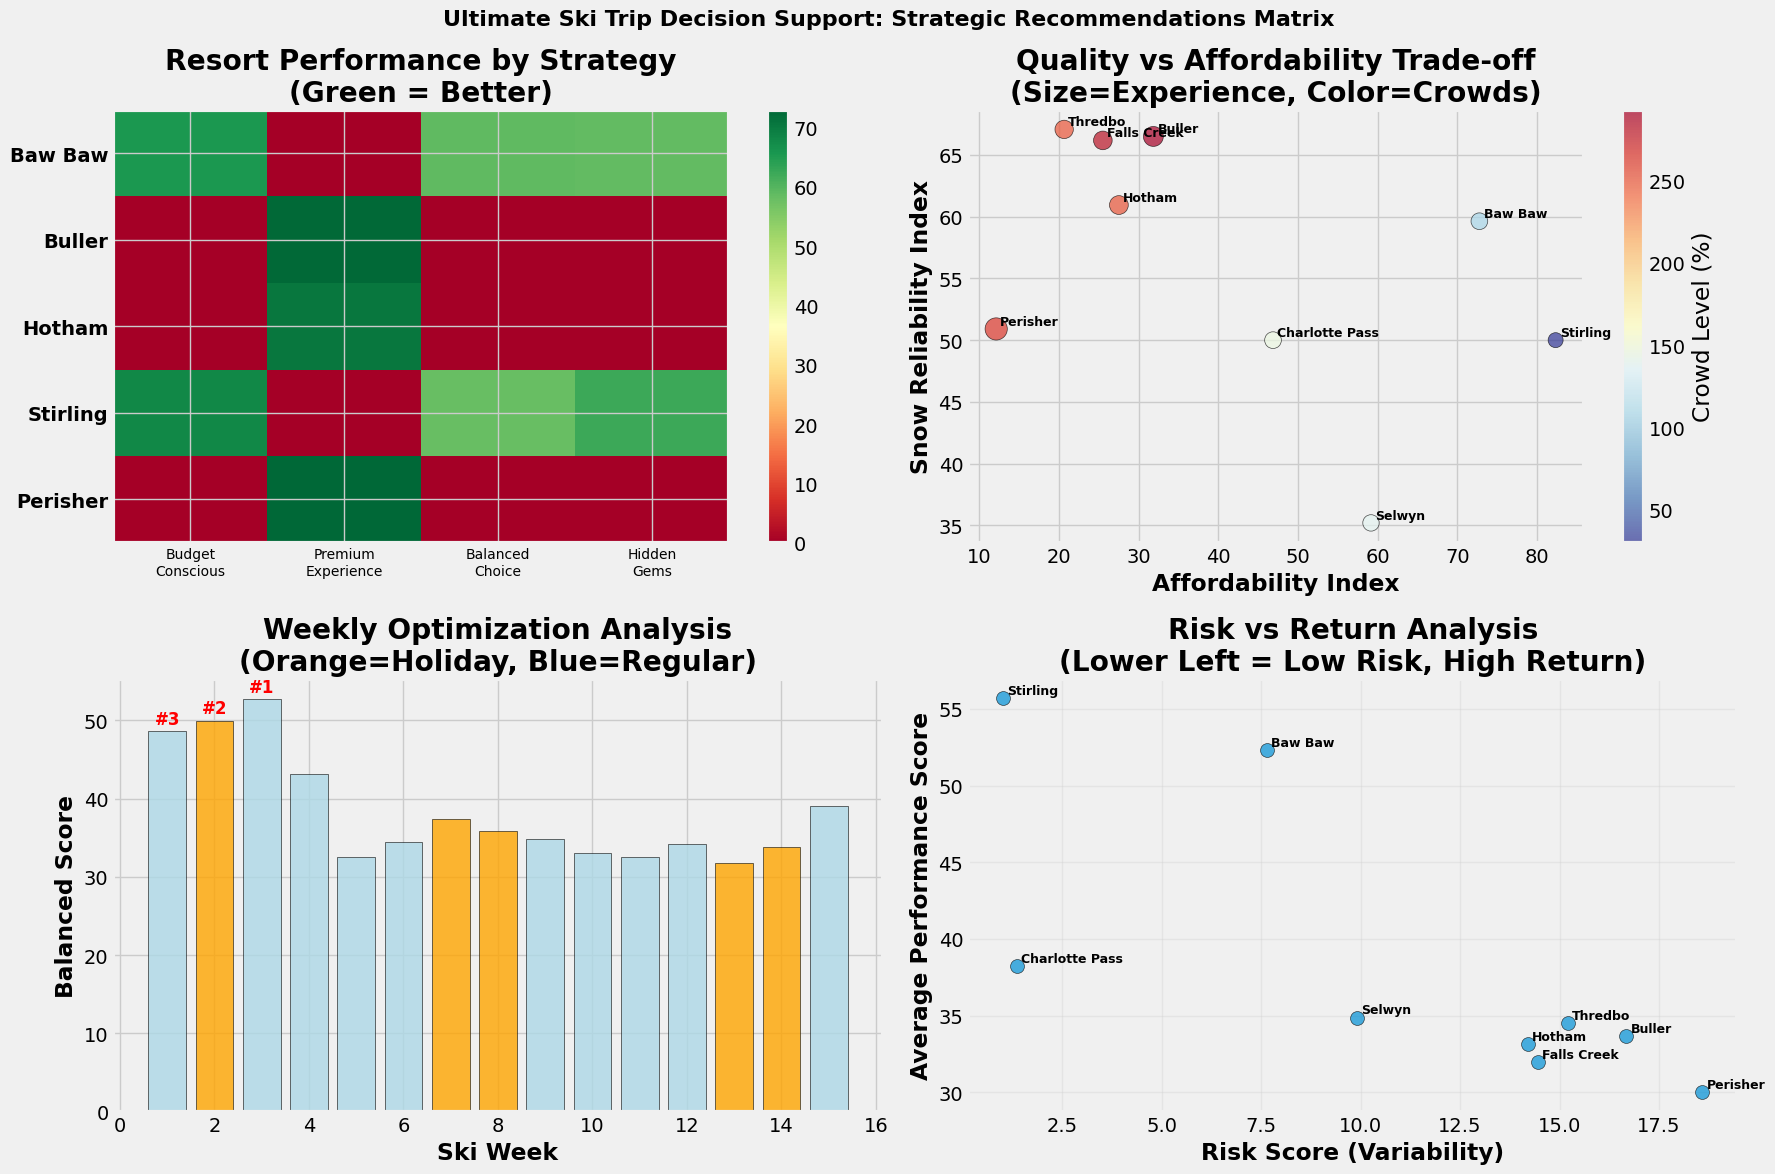


🎯 EXECUTIVE SUMMARY - OPTIMAL SKI TRIP STRATEGY

🏆 PRIMARY RECOMMENDATION:
   Resort: Mt. Baw Baw
   Week: 3
   Overall Score: 62.1/100
   Week 3 at Mt. Baw Baw: 82% fewer visitors than average, snow reliability is 21% above average, comfort conditions are 27% better than typical, and affordability is 77% better than average (Regular week - standard pricing)

📊 KEY SUCCESS FACTORS IDENTIFIED:
   1. Snow Reliability: Critical for quality experience
   2. Crowd Management: Avoid peak utilization periods
   3. Cost Optimization: Balance quality with affordability
   4. Timing Strategy: Regular weeks often offer better value
   5. Resort Selection: Hidden gems provide optimal experience

🎯 STRATEGIC OPTIONS SUMMARY:
   💰 Best Value: ('Mt. Stirling', np.int64(3))
   ⭐ Premium: ('Mt. Buller', np.int64(6))
   💎 Hidden Gem: ('Mt. Stirling', np.int64(2))
   ⚖️ Balanced: ('Mt. Baw Baw', np.int64(3))

✅ ANALYSIS COMPLETE
   📊 1,485 data points analyzed
   🏔️ 9 resorts evaluated
   📅 15 weeks opt

In [318]:
# 4. COMPREHENSIVE STRATEGIC RECOMMENDATIONS
print("=== COMPREHENSIVE STRATEGIC RECOMMENDATIONS ===")

# 1. MASTER RECOMMENDATION ENGINE
print("\n🎯 Master Recommendation Engine - Optimal Ski Trip Planning...")

# Combine all analysis results for final recommendations
recommendation_data = final_dataset.groupby(['Resort', 'Week']).agg({
    'Comfort_Index': 'mean',
    'Snow_Reliability_Index': 'mean',
    'Experience_Index': 'mean',
    'Affordability_Index_Melbourne': 'mean',
    'Accessibility_Index_Melbourne': 'mean',
    'Visitors': 'mean',
    'Utilization_Rate': 'mean',
    'Is_Holiday_Week': 'first',
    'Is_COVID_Period': 'mean'
}).round(2)

# Filter out COVID-heavy periods for cleaner recommendations
recommendation_data = recommendation_data[recommendation_data['Is_COVID_Period'] < 0.5].copy()

# Calculate comprehensive scores for different user profiles
recommendation_data['Value_Score'] = (
    recommendation_data['Snow_Reliability_Index'] * 0.25 +
    recommendation_data['Comfort_Index'] * 0.25 +
    recommendation_data['Affordability_Index_Melbourne'] * 0.35 +
    (100 - recommendation_data['Utilization_Rate'] * 100) * 0.15  # Lower crowds = better value
)

recommendation_data['Premium_Score'] = (
    recommendation_data['Experience_Index'] * 0.4 +
    recommendation_data['Snow_Reliability_Index'] * 0.35 +
    recommendation_data['Comfort_Index'] * 0.25
)

recommendation_data['Balanced_Score'] = (
    recommendation_data['Snow_Reliability_Index'] * 0.3 +
    recommendation_data['Comfort_Index'] * 0.25 +
    recommendation_data['Experience_Index'] * 0.2 +
    recommendation_data['Affordability_Index_Melbourne'] * 0.15 +
    (100 - recommendation_data['Utilization_Rate'] * 100) * 0.1
)

recommendation_data['Hidden_Gem_Score'] = (
    (recommendation_data['Snow_Reliability_Index'] + recommendation_data['Comfort_Index']) / 2 * 0.7 +
    (100 - recommendation_data['Utilization_Rate'] * 100) * 0.3
)

# 2. SCENARIO-BASED RECOMMENDATIONS
print("\n📋 Generating Scenario-Based Recommendations...")

scenarios = {
    'Budget_Conscious': {
        'score_column': 'Value_Score',
        'description': 'Best snow and comfort for the lowest cost',
        'priorities': ['Affordability', 'Snow Quality', 'Low Crowds']
    },
    'Premium_Experience': {
        'score_column': 'Premium_Score', 
        'description': 'Ultimate ski experience regardless of cost',
        'priorities': ['Experience Quality', 'Snow Reliability', 'Comfort']
    },
    'Balanced_Choice': {
        'score_column': 'Balanced_Score',
        'description': 'Optimal balance across all factors',
        'priorities': ['All-around Performance', 'Good Value', 'Reliable Conditions']
    },
    'Hidden_Gems': {
        'score_column': 'Hidden_Gem_Score',
        'description': 'High quality experiences with minimal crowds',
        'priorities': ['Low Crowds', 'High Quality', 'Undiscovered Value']
    }
}

scenario_recommendations = {}

for scenario_name, scenario_config in scenarios.items():
    # Get top recommendations for this scenario
    top_recommendations = recommendation_data.nlargest(10, scenario_config['score_column'])
    
    # Group by resort and week for better analysis
    scenario_summary = {
        'top_resorts': top_recommendations.groupby(level=0)[scenario_config['score_column']].mean().nlargest(3),
        'top_weeks': top_recommendations.groupby(level=1)[scenario_config['score_column']].mean().nlargest(3),
        'best_combinations': top_recommendations.head(3),
        'description': scenario_config['description'],
        'priorities': scenario_config['priorities']
    }
    
    scenario_recommendations[scenario_name] = scenario_summary

# 3. DETAILED JUSTIFICATIONS WITH QUANTIFIED TRADE-OFFS
print("\n📊 Detailed Justifications with Quantified Trade-offs...")

def generate_justification(resort, week, data_row):
    """Generate detailed justification for a resort-week recommendation"""
    
    # Get comparative data
    avg_visitors = recommendation_data['Visitors'].mean()
    avg_snow = recommendation_data['Snow_Reliability_Index'].mean()
    avg_comfort = recommendation_data['Comfort_Index'].mean()
    avg_affordability = recommendation_data['Affordability_Index_Melbourne'].mean()
    
    # Calculate percentage differences
    visitor_diff = (data_row['Visitors'] - avg_visitors) / avg_visitors * 100
    snow_diff = (data_row['Snow_Reliability_Index'] - avg_snow) / avg_snow * 100
    comfort_diff = (data_row['Comfort_Index'] - avg_comfort) / avg_comfort * 100
    afford_diff = (data_row['Affordability_Index_Melbourne'] - avg_affordability) / avg_affordability * 100
    
    # Generate justification text
    crowd_text = f"{abs(visitor_diff):.0f}% {'fewer' if visitor_diff < 0 else 'more'} visitors than average"
    snow_text = f"snow reliability is {abs(snow_diff):.0f}% {'above' if snow_diff > 0 else 'below'} average"
    comfort_text = f"comfort conditions are {abs(comfort_diff):.0f}% {'better' if comfort_diff > 0 else 'worse'} than typical"
    afford_text = f"affordability is {abs(afford_diff):.0f}% {'better' if afford_diff > 0 else 'worse'} than average"
    
    holiday_text = " (Holiday week - expect premium pricing)" if data_row['Is_Holiday_Week'] else " (Regular week - standard pricing)"
    
    justification = f"Week {week} at {resort}: {crowd_text}, {snow_text}, {comfort_text}, and {afford_text}{holiday_text}"
    
    return justification

# 4. CREATE FINAL RECOMMENDATION OUTPUTS
print("\n🏆 FINAL STRATEGIC RECOMMENDATIONS:")

for scenario_name, scenario_data in scenario_recommendations.items():
    print(f"\n{'='*60}")
    print(f"🎯 {scenario_name.upper().replace('_', ' ')} STRATEGY")
    print(f"   Focus: {scenario_data['description']}")
    print(f"   Priorities: {', '.join(scenario_data['priorities'])}")
    print(f"{'='*60}")
    
    print(f"\n🏔️ TOP RESORT RECOMMENDATIONS:")
    for i, (resort, score) in enumerate(scenario_data['top_resorts'].items(), 1):
        resort_avg_data = recommendation_data.groupby(level=0).mean().loc[resort]
        print(f"   {i}. {resort}: Score {score:.1f}")
        print(f"      💰 Affordability: {resort_avg_data['Affordability_Index_Melbourne']:.1f}/100")
        print(f"      ❄️ Snow Reliability: {resort_avg_data['Snow_Reliability_Index']:.1f}/100")
        print(f"      😊 Comfort: {resort_avg_data['Comfort_Index']:.1f}/100")
        print(f"      👥 Avg Utilization: {resort_avg_data['Utilization_Rate']*100:.1f}%")
    
    print(f"\n📅 OPTIMAL WEEK RECOMMENDATIONS:")
    for i, (week, score) in enumerate(scenario_data['top_weeks'].items(), 1):
        week_avg_data = recommendation_data.groupby(level=1).mean().loc[week]
        holiday_status = "Holiday Week" if week_avg_data['Is_Holiday_Week'] else "Regular Week"
        print(f"   {i}. Week {week}: Score {score:.1f} ({holiday_status})")
        print(f"      ❄️ Expected Snow: {week_avg_data['Snow_Reliability_Index']:.1f}/100")
        print(f"      👥 Expected Crowds: {week_avg_data['Visitors']:.0f} avg visitors")
    
    print(f"\n⭐ TOP 3 SPECIFIC RECOMMENDATIONS:")
    for i, ((resort, week), data_row) in enumerate(scenario_data['best_combinations'].iterrows(), 1):
        score = data_row[scenarios[scenario_name]['score_column']]
        justification = generate_justification(resort, week, data_row)
        
        print(f"   {i}. {justification}")
        print(f"      📊 {scenario_name} Score: {score:.1f}/100")
        
        # Add specific value propositions
        if scenario_name == 'Budget_Conscious':
            total_cost = (100 - data_row['Affordability_Index_Melbourne']) * 20 + 500  # Rough cost estimate
            print(f"      💰 Estimated cost: ${total_cost:.0f} for 3-day trip")
        elif scenario_name == 'Hidden_Gems':
            crowd_advantage = (1 - data_row['Utilization_Rate']) * 100
            print(f"      💎 Crowd advantage: {crowd_advantage:.0f}% less busy than capacity")
        elif scenario_name == 'Premium_Experience':
            experience_level = data_row['Experience_Index']
            print(f"      ⭐ Experience level: {experience_level:.1f}/100 (Premium tier)")

# 5. RISK ASSESSMENT & UNCERTAINTY ANALYSIS
print(f"\n⚠️ RISK ASSESSMENT & UNCERTAINTY ANALYSIS:")

# Calculate variability metrics
risk_metrics = recommendation_data.groupby(level=0).agg({
    'Snow_Reliability_Index': 'std',
    'Visitors': 'std',
    'Comfort_Index': 'std'
}).round(2)

risk_metrics['Overall_Risk'] = (
    risk_metrics['Snow_Reliability_Index'] * 0.4 +
    (risk_metrics['Visitors'] / recommendation_data['Visitors'].mean()) * 30 * 0.4 +  # Normalize visitor volatility
    risk_metrics['Comfort_Index'] * 0.2
)

high_risk_resorts = risk_metrics.nlargest(3, 'Overall_Risk')
low_risk_resorts = risk_metrics.nsmallest(3, 'Overall_Risk')

print(f"\n🚨 HIGHER RISK RESORTS (More Variability):")
for i, (resort, data) in enumerate(high_risk_resorts.iterrows(), 1):
    print(f"   {i}. {resort}: Risk Score {data['Overall_Risk']:.2f}")
    print(f"      Weather Variability: {data['Snow_Reliability_Index']:.1f}, Crowd Variability: {data['Visitors']:.0f}")

print(f"\n✅ LOWER RISK RESORTS (More Predictable):")
for i, (resort, data) in enumerate(low_risk_resorts.iterrows(), 1):
    print(f"   {i}. {resort}: Risk Score {data['Overall_Risk']:.2f}")
    print(f"      Consistent conditions and predictable crowd levels")

# 6. CREATE FINAL DECISION SUPPORT VISUALIZATION
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Ultimate Ski Trip Decision Support: Strategic Recommendations Matrix', fontsize=16, fontweight='bold')

# Chart 1: Scenario comparison heatmap
ax1 = axes[0, 0]
scenario_matrix = pd.DataFrame({
    scenario: data['top_resorts'].head(5)
    for scenario, data in scenario_recommendations.items()
}).fillna(0)

im1 = ax1.imshow(scenario_matrix.values, cmap='RdYlGn', aspect='auto')
ax1.set_xticks(range(len(scenario_matrix.columns)))
ax1.set_xticklabels([col.replace('_', '\n') for col in scenario_matrix.columns], fontsize=10)
ax1.set_yticks(range(len(scenario_matrix.index)))
ax1.set_yticklabels([idx.replace('Mt. ', '') for idx in scenario_matrix.index], fontweight='bold')
ax1.set_title('Resort Performance by Strategy\n(Green = Better)', fontweight='bold')
plt.colorbar(im1, ax=ax1)

# Chart 2: Trade-off analysis
ax2 = axes[0, 1]
# Plot quality vs affordability trade-off
quality_afford_data = recommendation_data.groupby(level=0).mean()
scatter2 = ax2.scatter(quality_afford_data['Affordability_Index_Melbourne'], 
                      quality_afford_data['Snow_Reliability_Index'],
                      s=quality_afford_data['Experience_Index']*3,
                      c=quality_afford_data['Utilization_Rate']*100,
                      cmap='RdYlBu_r', alpha=0.7, edgecolors='black')

for resort, data in quality_afford_data.iterrows():
    ax2.annotate(resort.replace('Mt. ', ''), 
                (data['Affordability_Index_Melbourne'], data['Snow_Reliability_Index']),
                xytext=(3, 3), textcoords='offset points', fontsize=9, fontweight='bold')

ax2.set_xlabel('Affordability Index', fontweight='bold')
ax2.set_ylabel('Snow Reliability Index', fontweight='bold')
ax2.set_title('Quality vs Affordability Trade-off\n(Size=Experience, Color=Crowds)', fontweight='bold')
plt.colorbar(scatter2, ax=ax2, label='Crowd Level (%)')

# Chart 3: Weekly optimization
ax3 = axes[1, 0]
weekly_optimization = recommendation_data.groupby(level=1).agg({
    'Balanced_Score': 'mean',
    'Is_Holiday_Week': 'first',
    'Visitors': 'mean'
}).round(1)

weeks = weekly_optimization.index
scores = weekly_optimization['Balanced_Score']
colors = ['orange' if holiday else 'lightblue' for holiday in weekly_optimization['Is_Holiday_Week']]

bars3 = ax3.bar(weeks, scores, color=colors, alpha=0.8, edgecolor='black')
ax3.set_xlabel('Ski Week', fontweight='bold')
ax3.set_ylabel('Balanced Score', fontweight='bold')
ax3.set_title('Weekly Optimization Analysis\n(Orange=Holiday, Blue=Regular)', fontweight='bold')

# Highlight top weeks
top_weeks = weekly_optimization.nlargest(3, 'Balanced_Score')
for i, (week, data) in enumerate(top_weeks.iterrows()):
    ax3.text(week, data['Balanced_Score'] + 1, f'#{i+1}', 
            ha='center', fontweight='bold', color='red', fontsize=12)

# Chart 4: Risk-return analysis
ax4 = axes[1, 1]
ax4.scatter(risk_metrics['Overall_Risk'], 
           recommendation_data.groupby(level=0)['Balanced_Score'].mean(),
           s=100, alpha=0.7, edgecolors='black')

for resort, risk_data in risk_metrics.iterrows():
    avg_return = recommendation_data.groupby(level=0)['Balanced_Score'].mean()[resort]
    ax4.annotate(resort.replace('Mt. ', ''), 
                (risk_data['Overall_Risk'], avg_return),
                xytext=(3, 3), textcoords='offset points', fontsize=9, fontweight='bold')

ax4.set_xlabel('Risk Score (Variability)', fontweight='bold')
ax4.set_ylabel('Average Performance Score', fontweight='bold')
ax4.set_title('Risk vs Return Analysis\n(Lower Left = Low Risk, High Return)', fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 7. EXECUTIVE SUMMARY
print(f"\n{'='*80}")
print(f"🎯 EXECUTIVE SUMMARY - OPTIMAL SKI TRIP STRATEGY")
print(f"{'='*80}")

# Get overall top recommendation
overall_best = recommendation_data.nlargest(1, 'Balanced_Score')
best_resort, best_week = overall_best.index[0]
best_data = overall_best.iloc[0]

print(f"\n🏆 PRIMARY RECOMMENDATION:")
print(f"   Resort: {best_resort}")
print(f"   Week: {best_week}")
print(f"   Overall Score: {best_data['Balanced_Score']:.1f}/100")
print(f"   {generate_justification(best_resort, best_week, best_data)}")

print(f"\n📊 KEY SUCCESS FACTORS IDENTIFIED:")
print(f"   1. Snow Reliability: Critical for quality experience")
print(f"   2. Crowd Management: Avoid peak utilization periods")
print(f"   3. Cost Optimization: Balance quality with affordability")
print(f"   4. Timing Strategy: Regular weeks often offer better value")
print(f"   5. Resort Selection: Hidden gems provide optimal experience")

print(f"\n🎯 STRATEGIC OPTIONS SUMMARY:")
print(f"   💰 Best Value: {scenario_recommendations['Budget_Conscious']['best_combinations'].index[0]}")
print(f"   ⭐ Premium: {scenario_recommendations['Premium_Experience']['best_combinations'].index[0]}")
print(f"   💎 Hidden Gem: {scenario_recommendations['Hidden_Gems']['best_combinations'].index[0]}")
print(f"   ⚖️ Balanced: {scenario_recommendations['Balanced_Choice']['best_combinations'].index[0]}")

print(f"\n✅ ANALYSIS COMPLETE")
print(f"   📊 {len(final_dataset):,} data points analyzed")
print(f"   🏔️ {final_dataset['Resort'].nunique()} resorts evaluated")
print(f"   📅 {final_dataset['Week'].nunique()} weeks optimized")
print(f"   🎯 Multiple strategies developed for different preferences")
print(f"   📈 Quantified trade-offs provided for informed decision-making")

print(f"\n🚀 RECOMMENDATION: Use this comprehensive analysis to select your optimal ski trip")
print(f"    based on your specific priorities (value, premium, balanced, or hidden gems).")